In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from main import load_and_prepare_sessions
from analysis.performance_funcs import add_performance_container
from processing.timepoint_analysis import aggregate_signals
from data.mouse import create_mice_dict

from collections import defaultdict
import matplotlib.pyplot as plt

sessions = load_and_prepare_sessions("../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
mice_dict = create_mice_dict(sessions)

In [3]:
for mouse in mice_dict.values():
    add_performance_container(mouse)

    for session in mouse.sessions:
        session.metric_container = mouse.metric_container

In [4]:
session_metric_order = defaultdict(list)

for idx, session in enumerate(sessions):
    for metric, val in session.metric_container.data.items():
        session_metric_order[metric].append((idx, val))

metric_session_order = {}
for metric, pairs in session_metric_order.items():
    sorted_metrics = sorted(pairs, key=lambda t: t[-1])
    metric_session_order[metric] = list(zip(*sorted_metrics))[0]

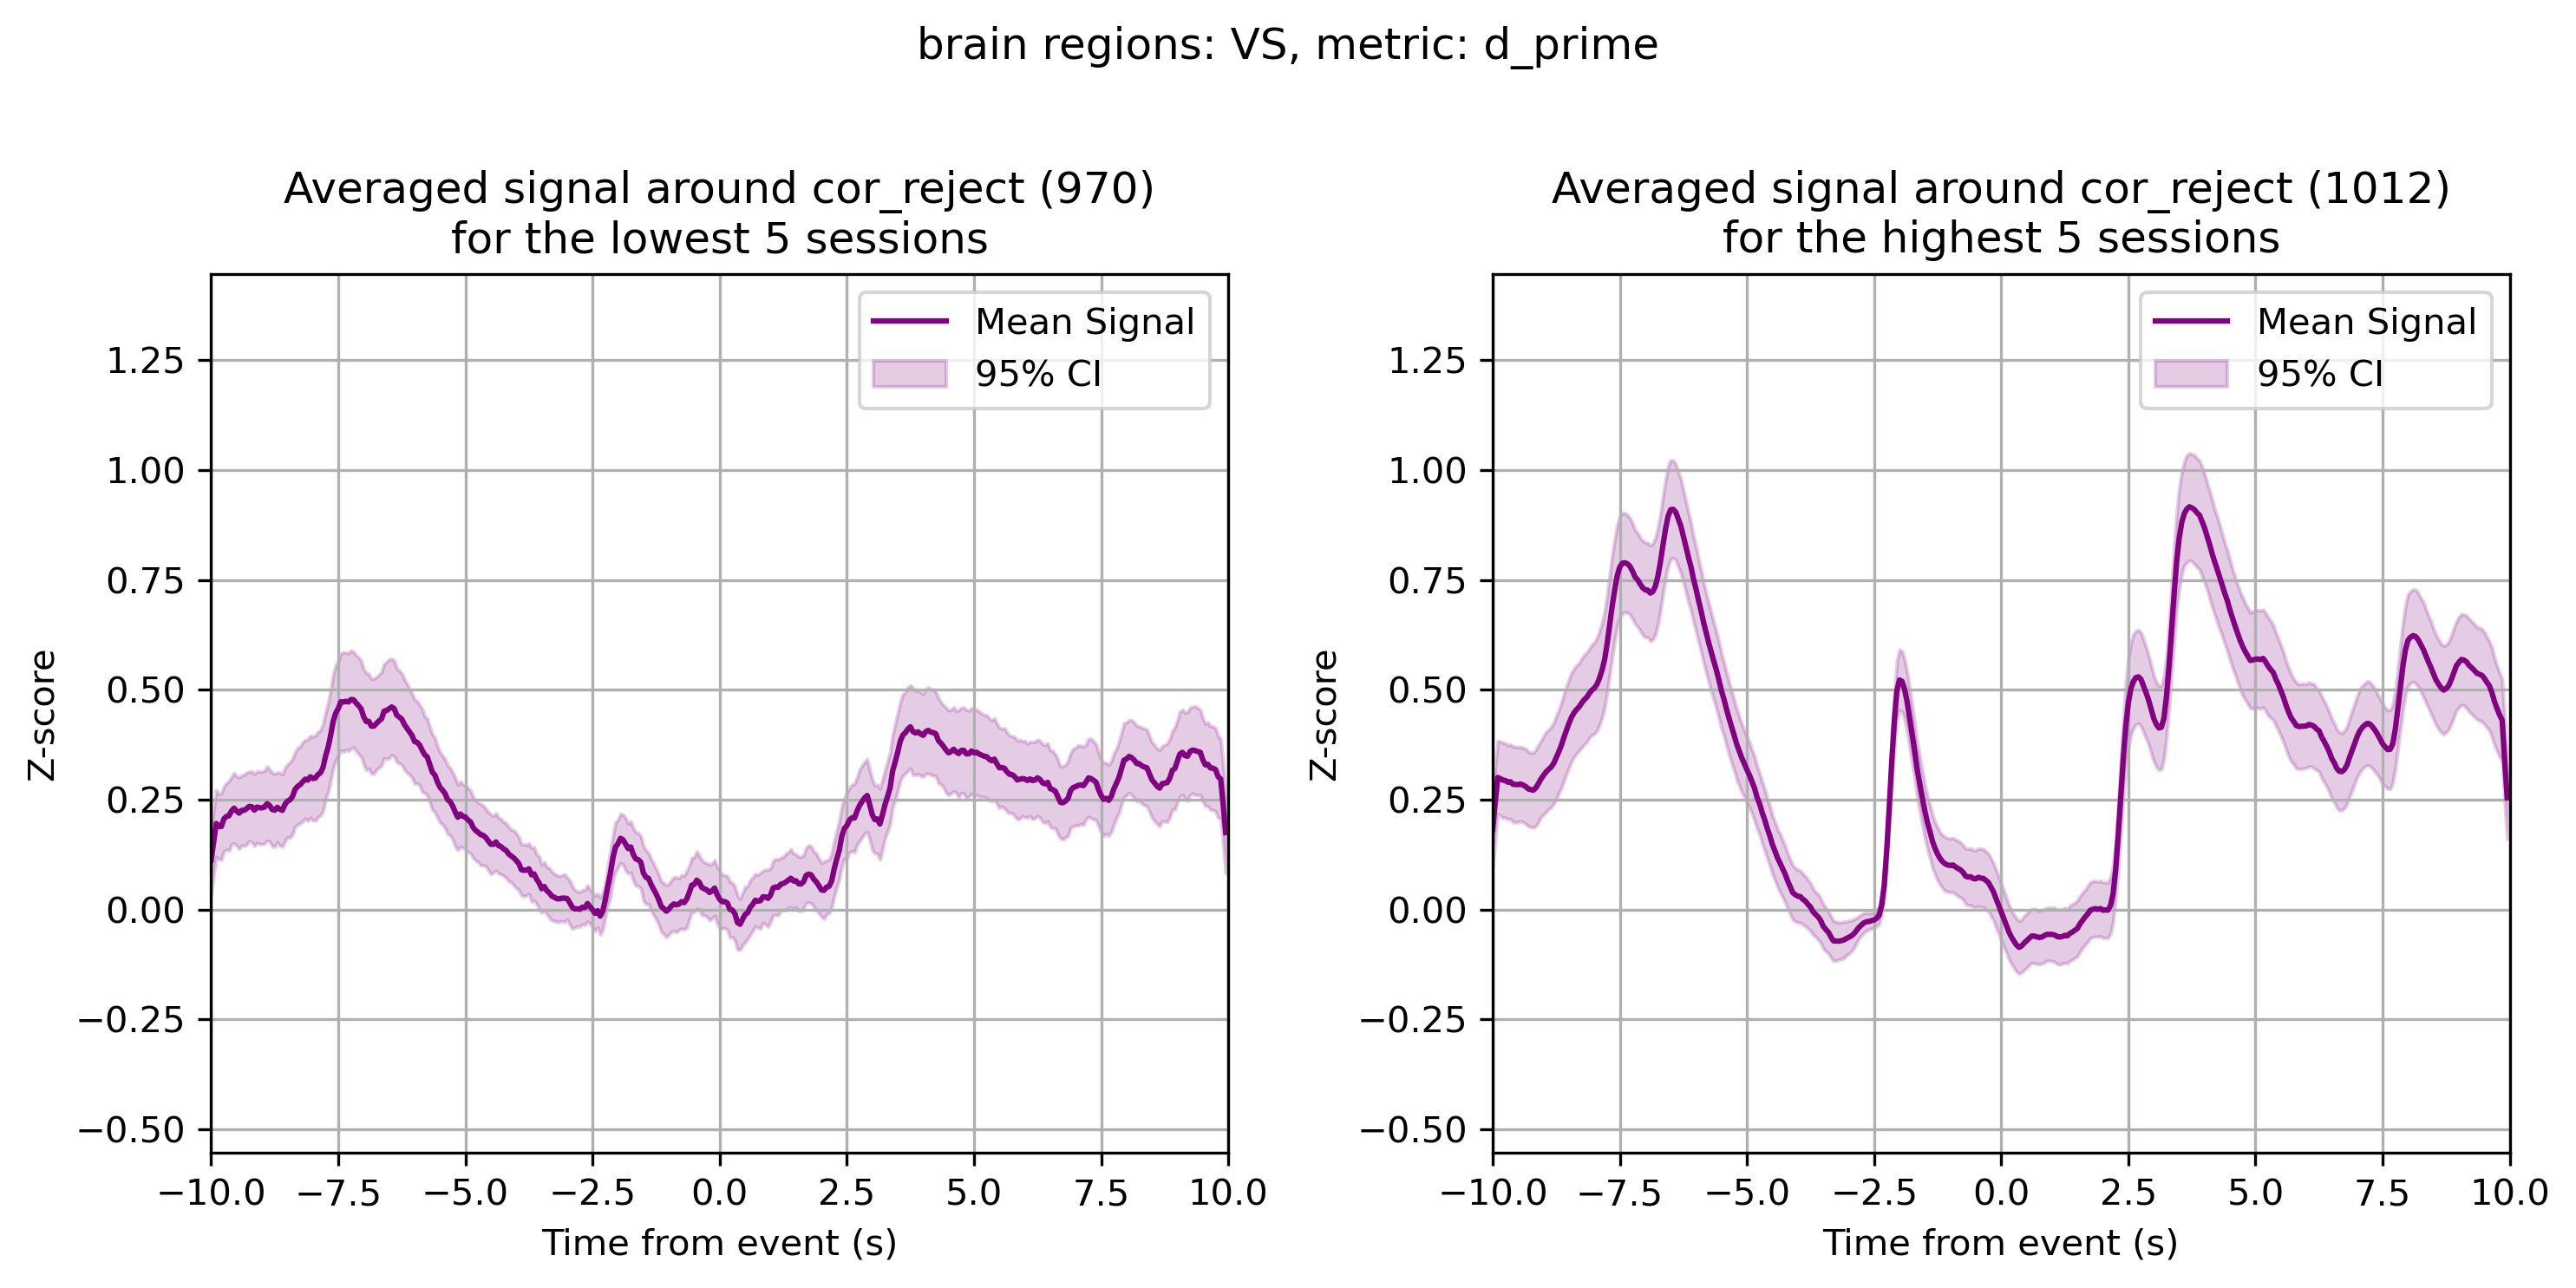

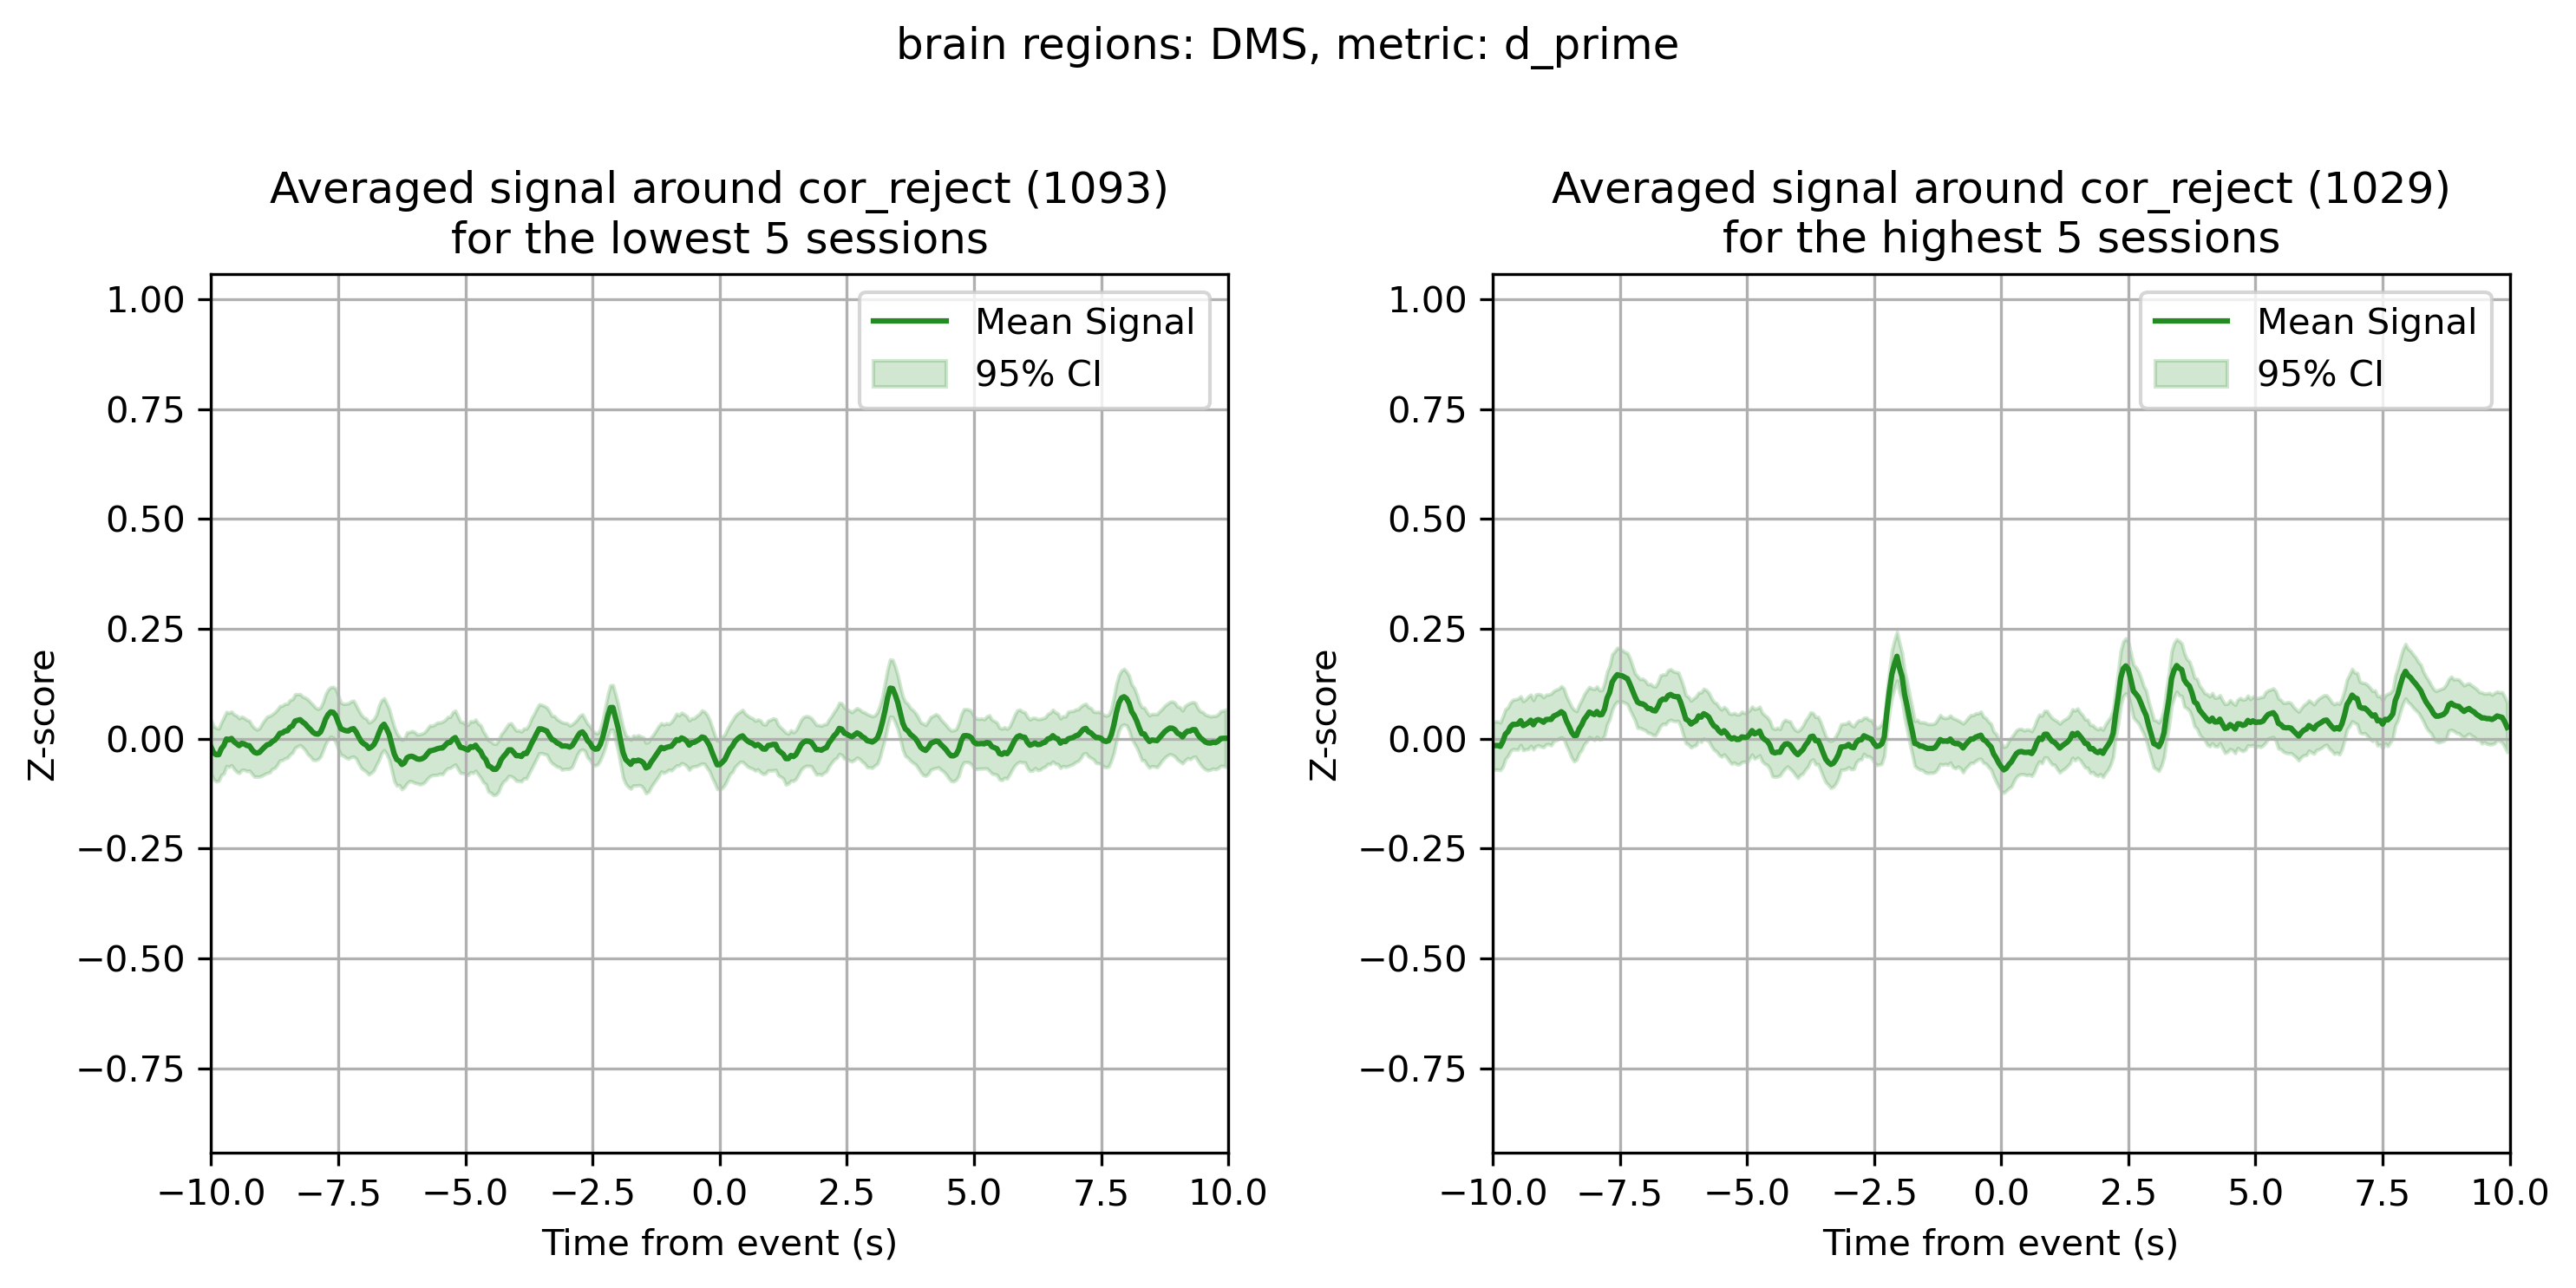

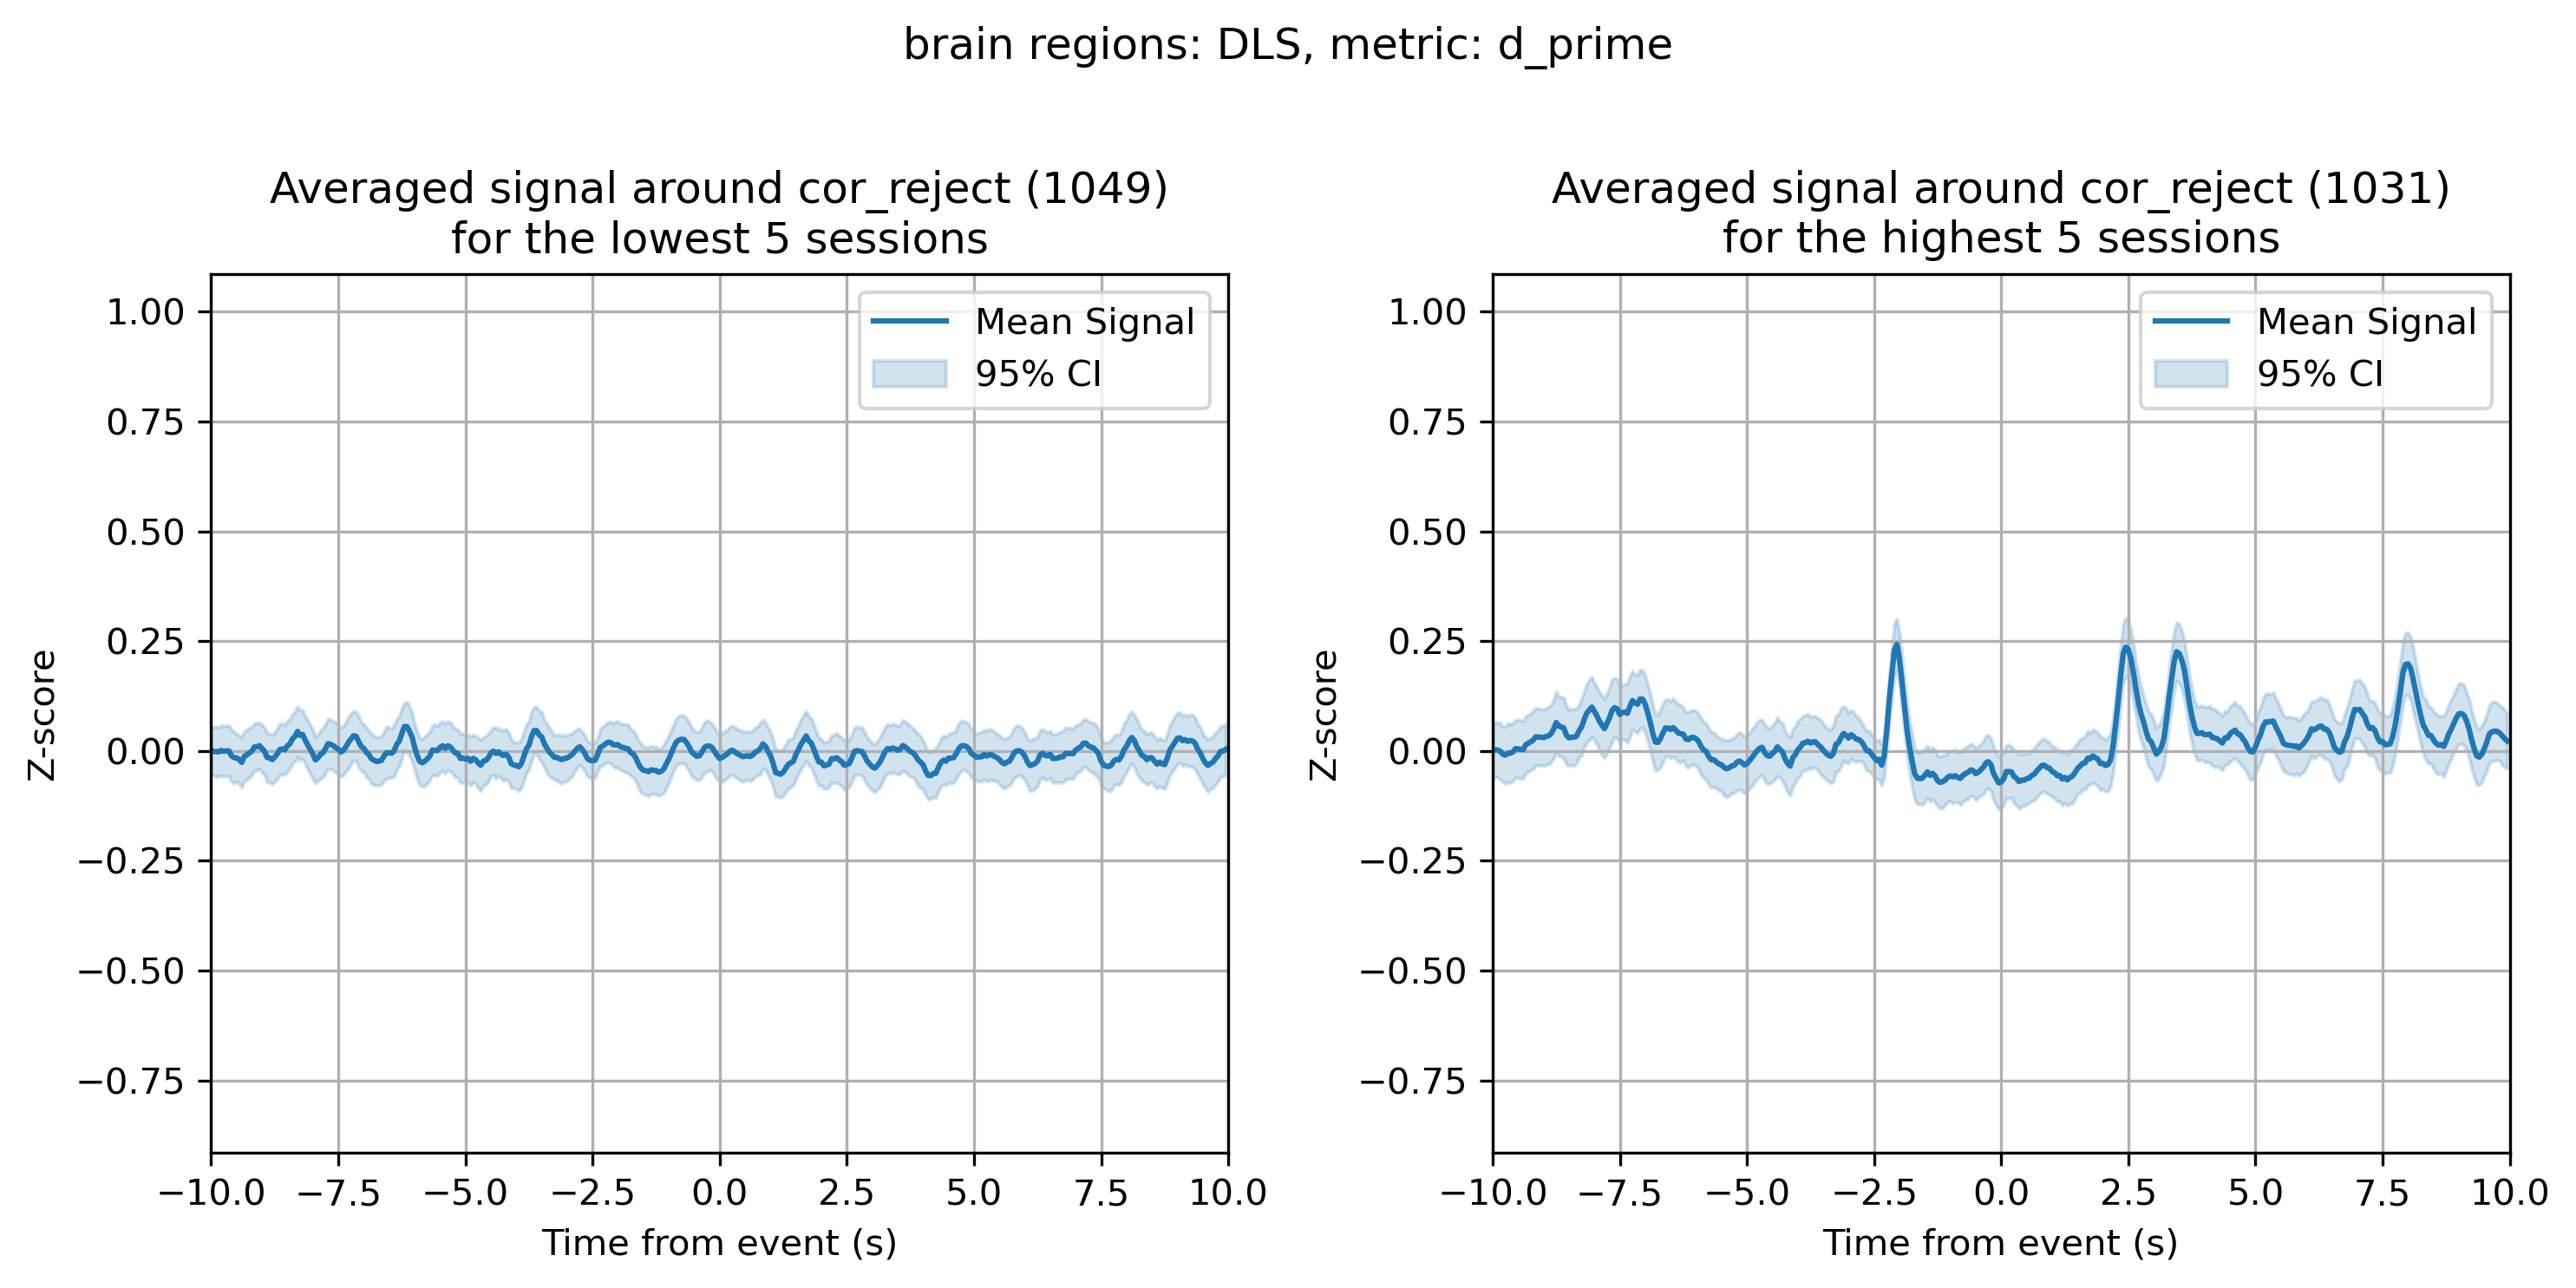

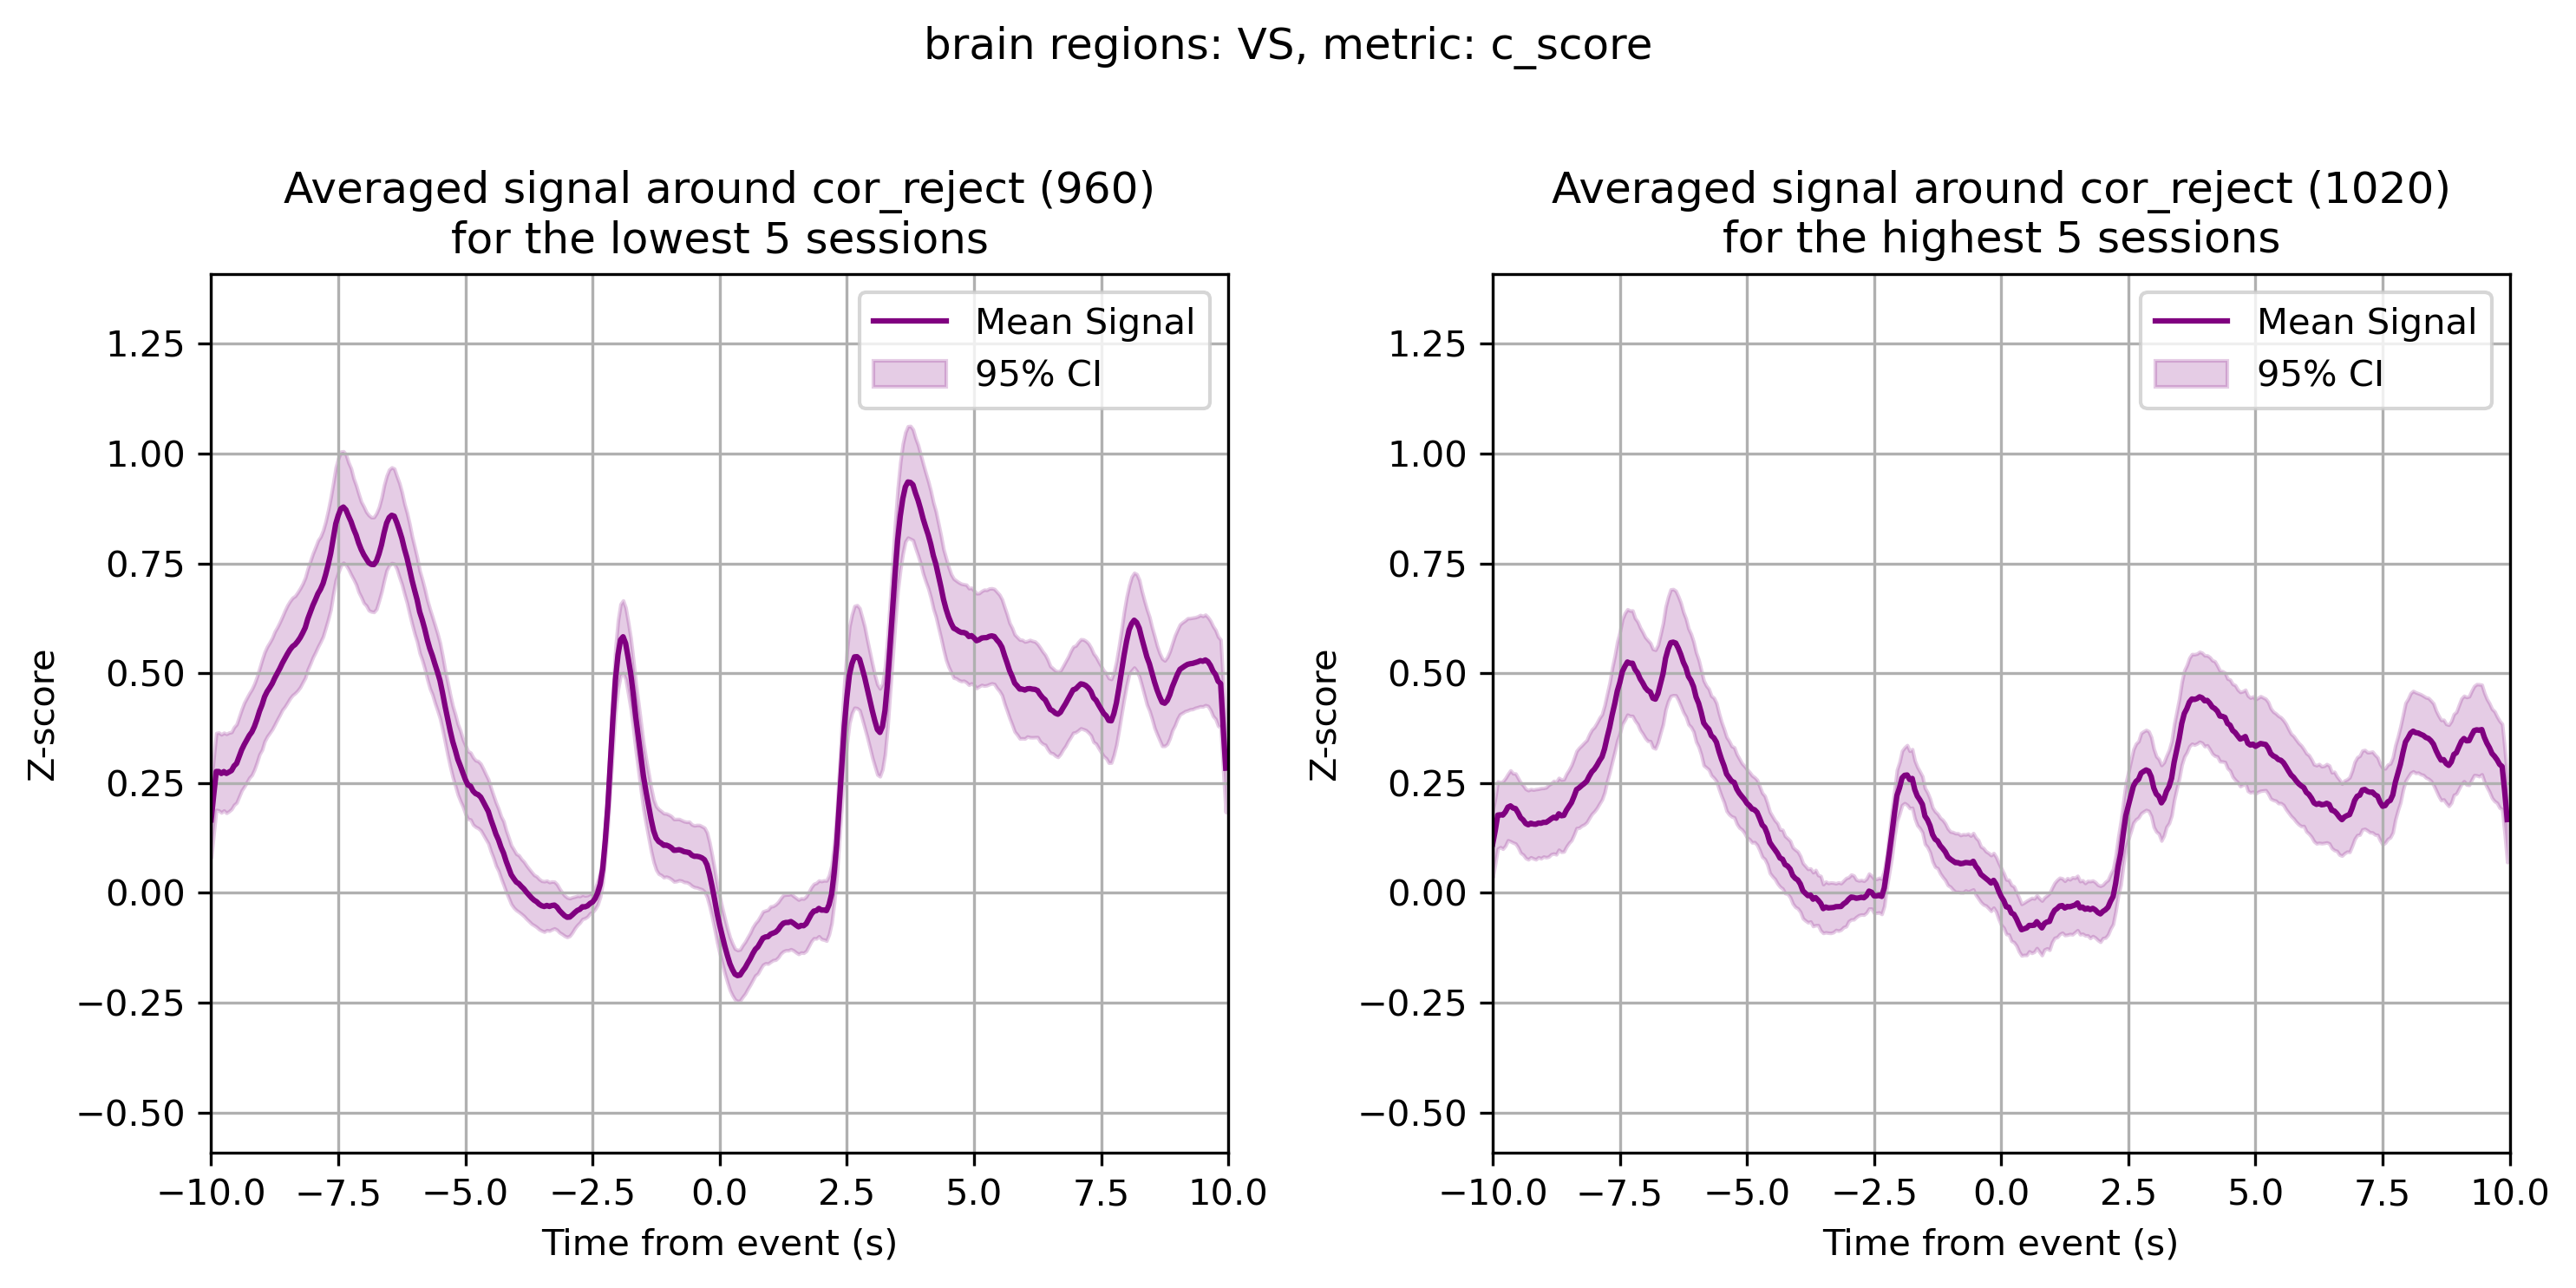

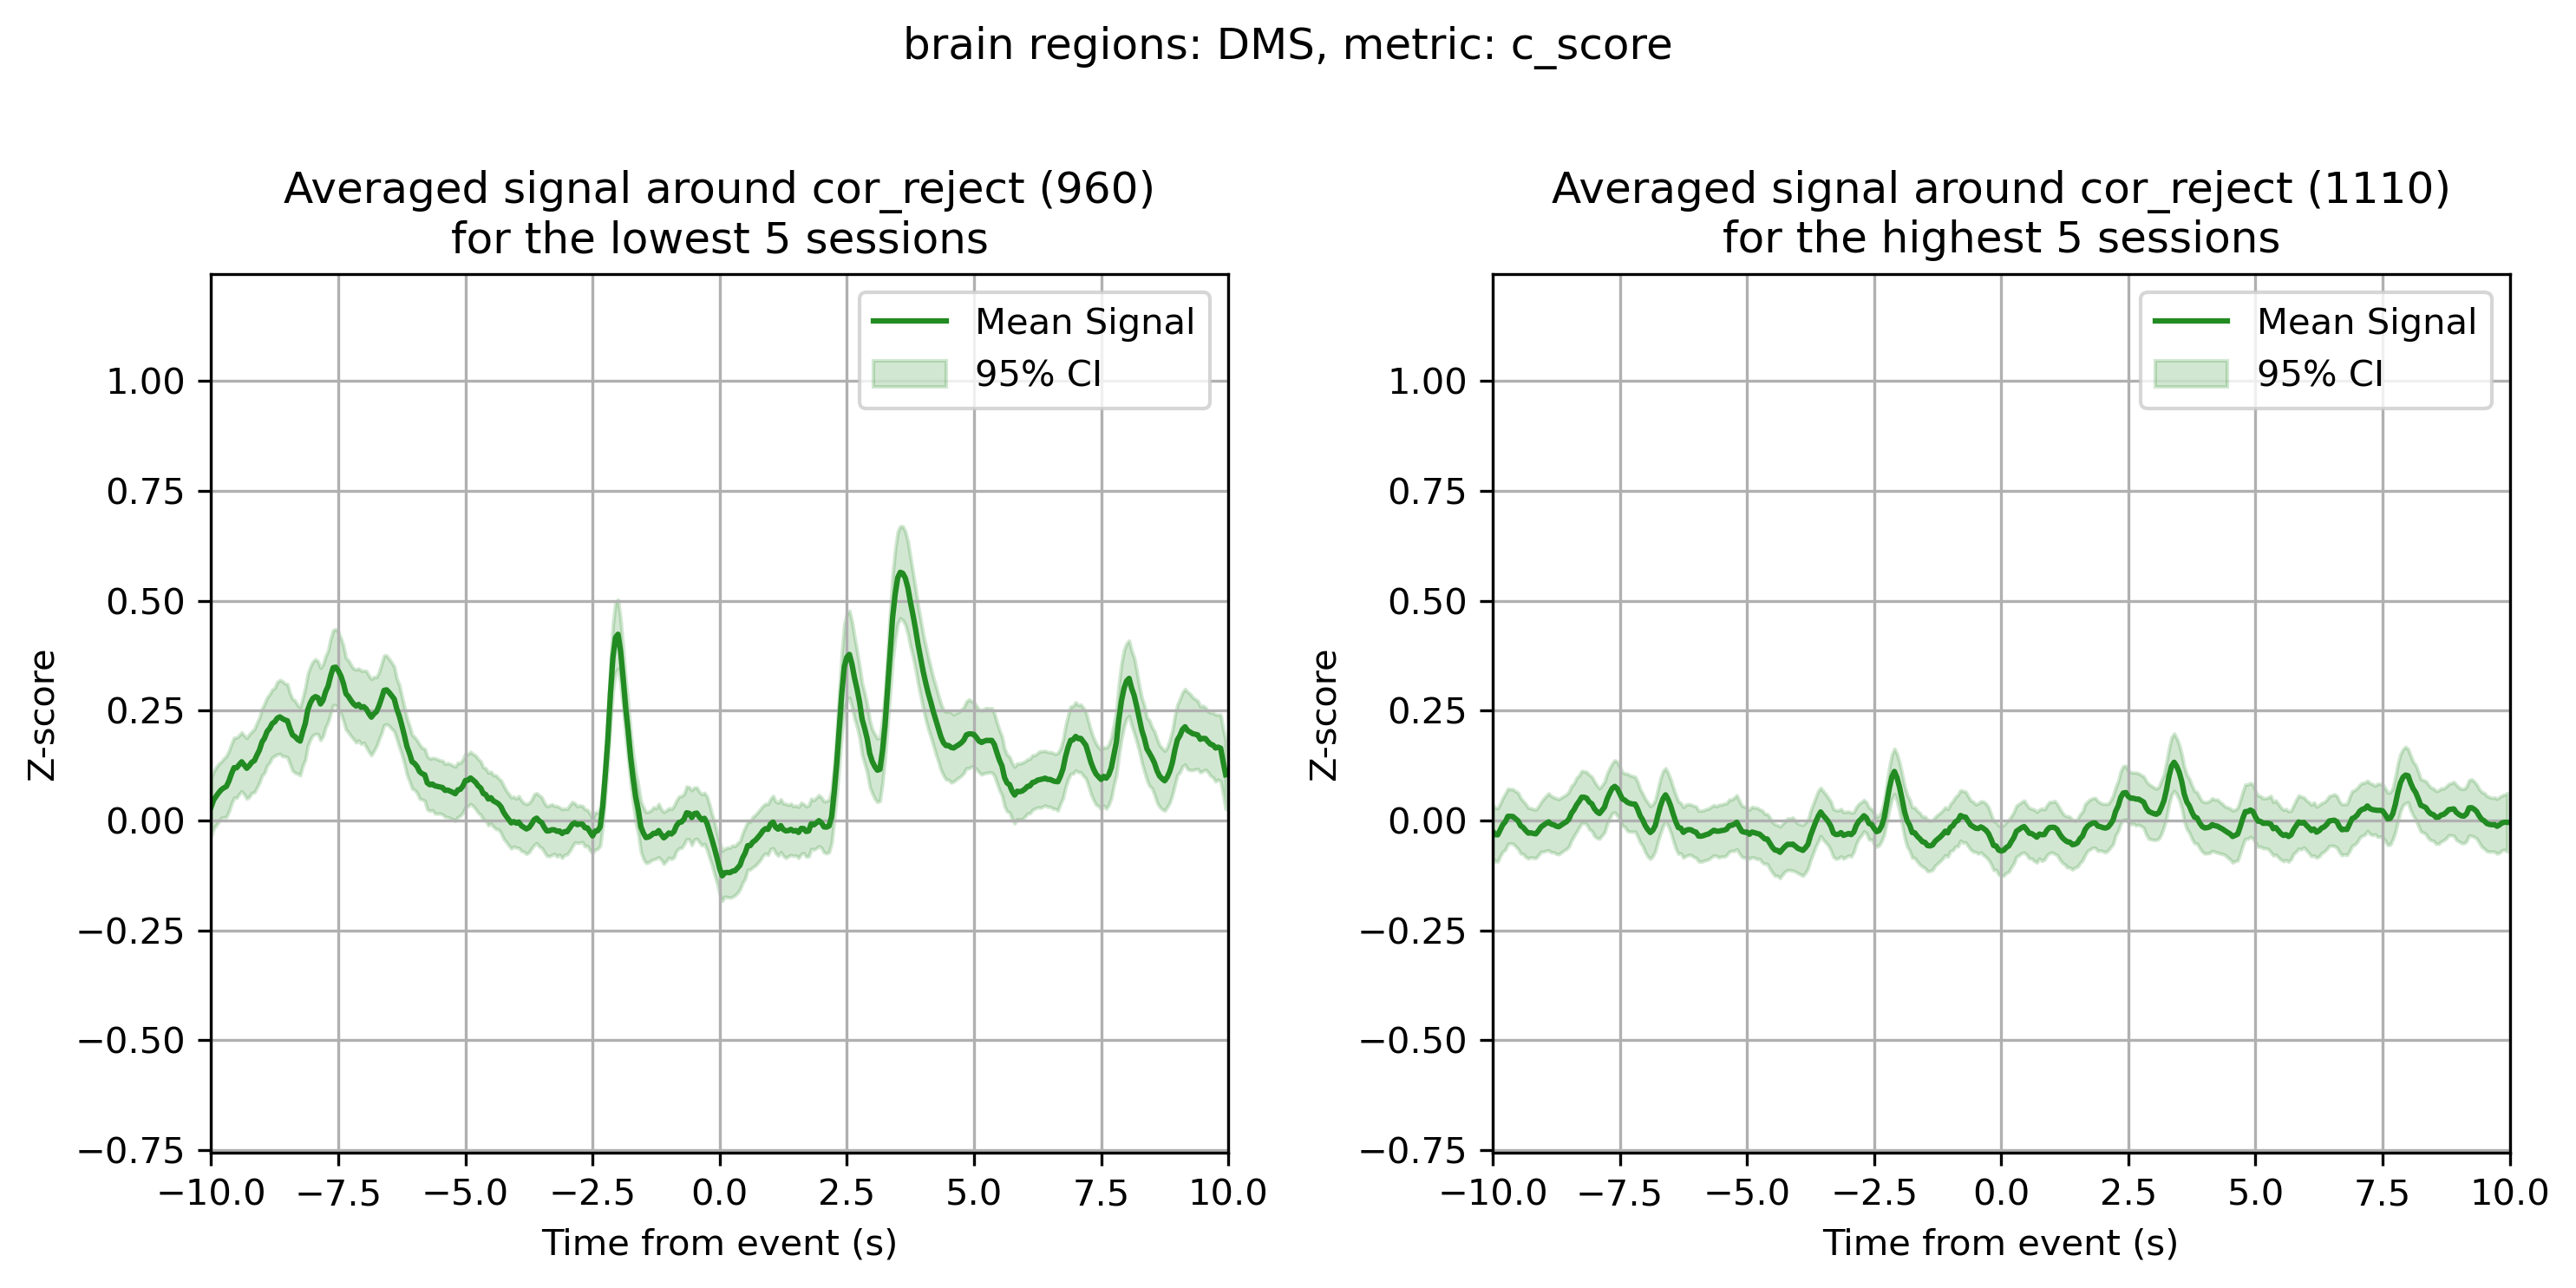

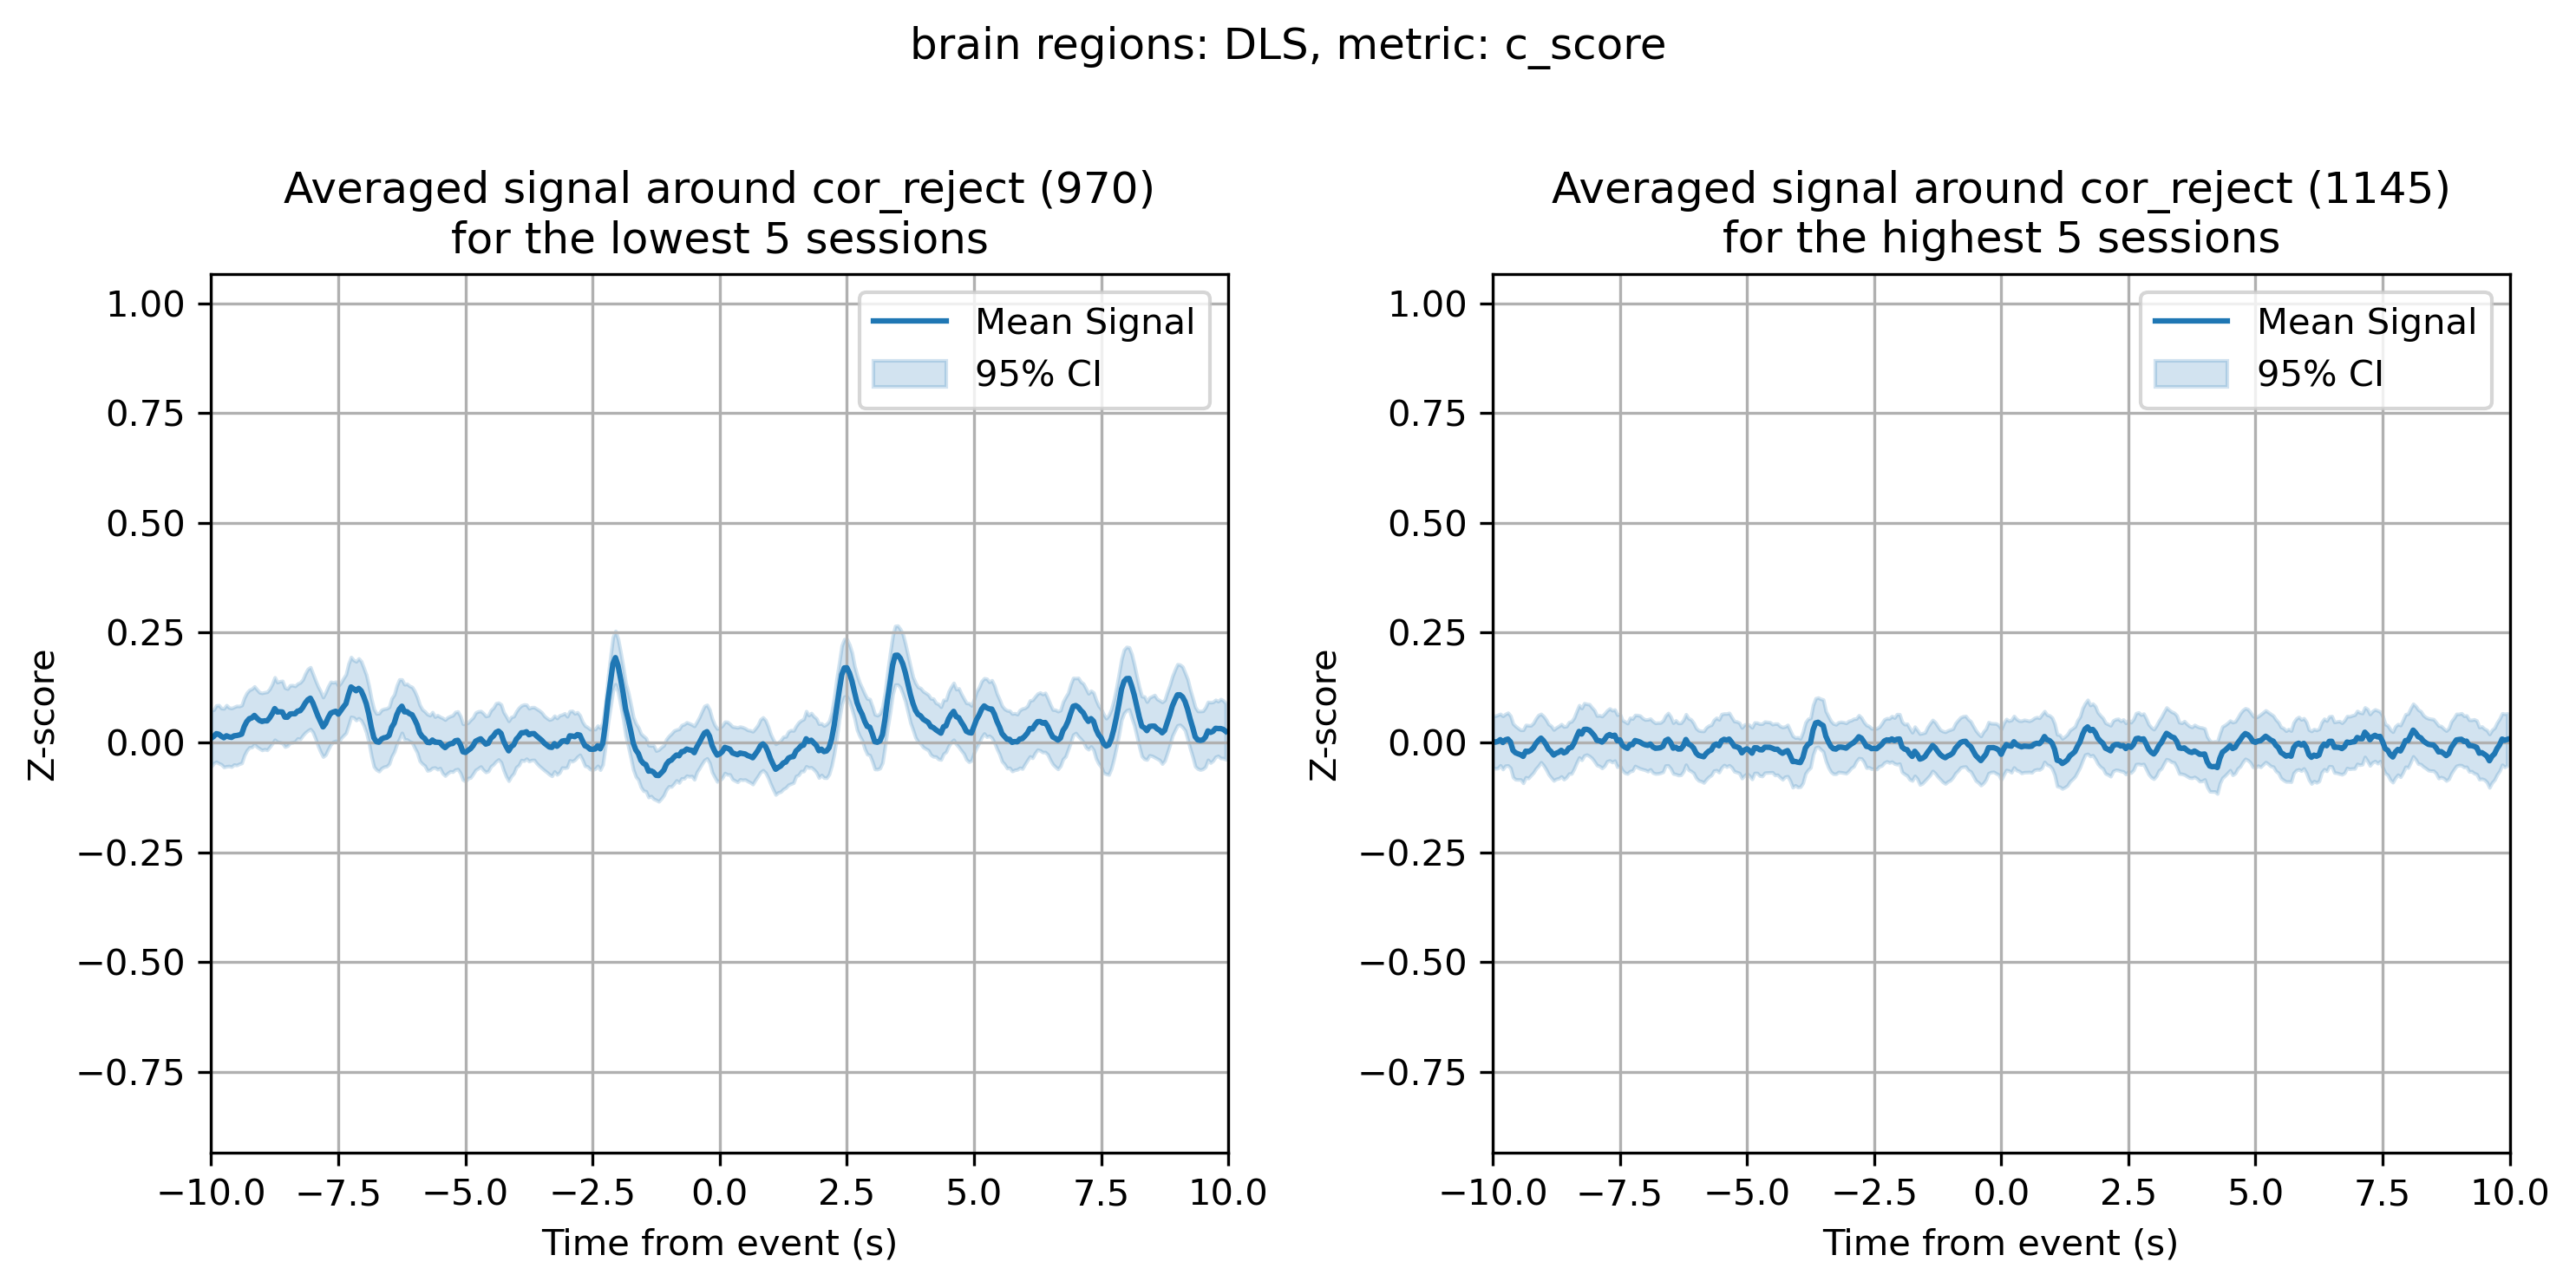

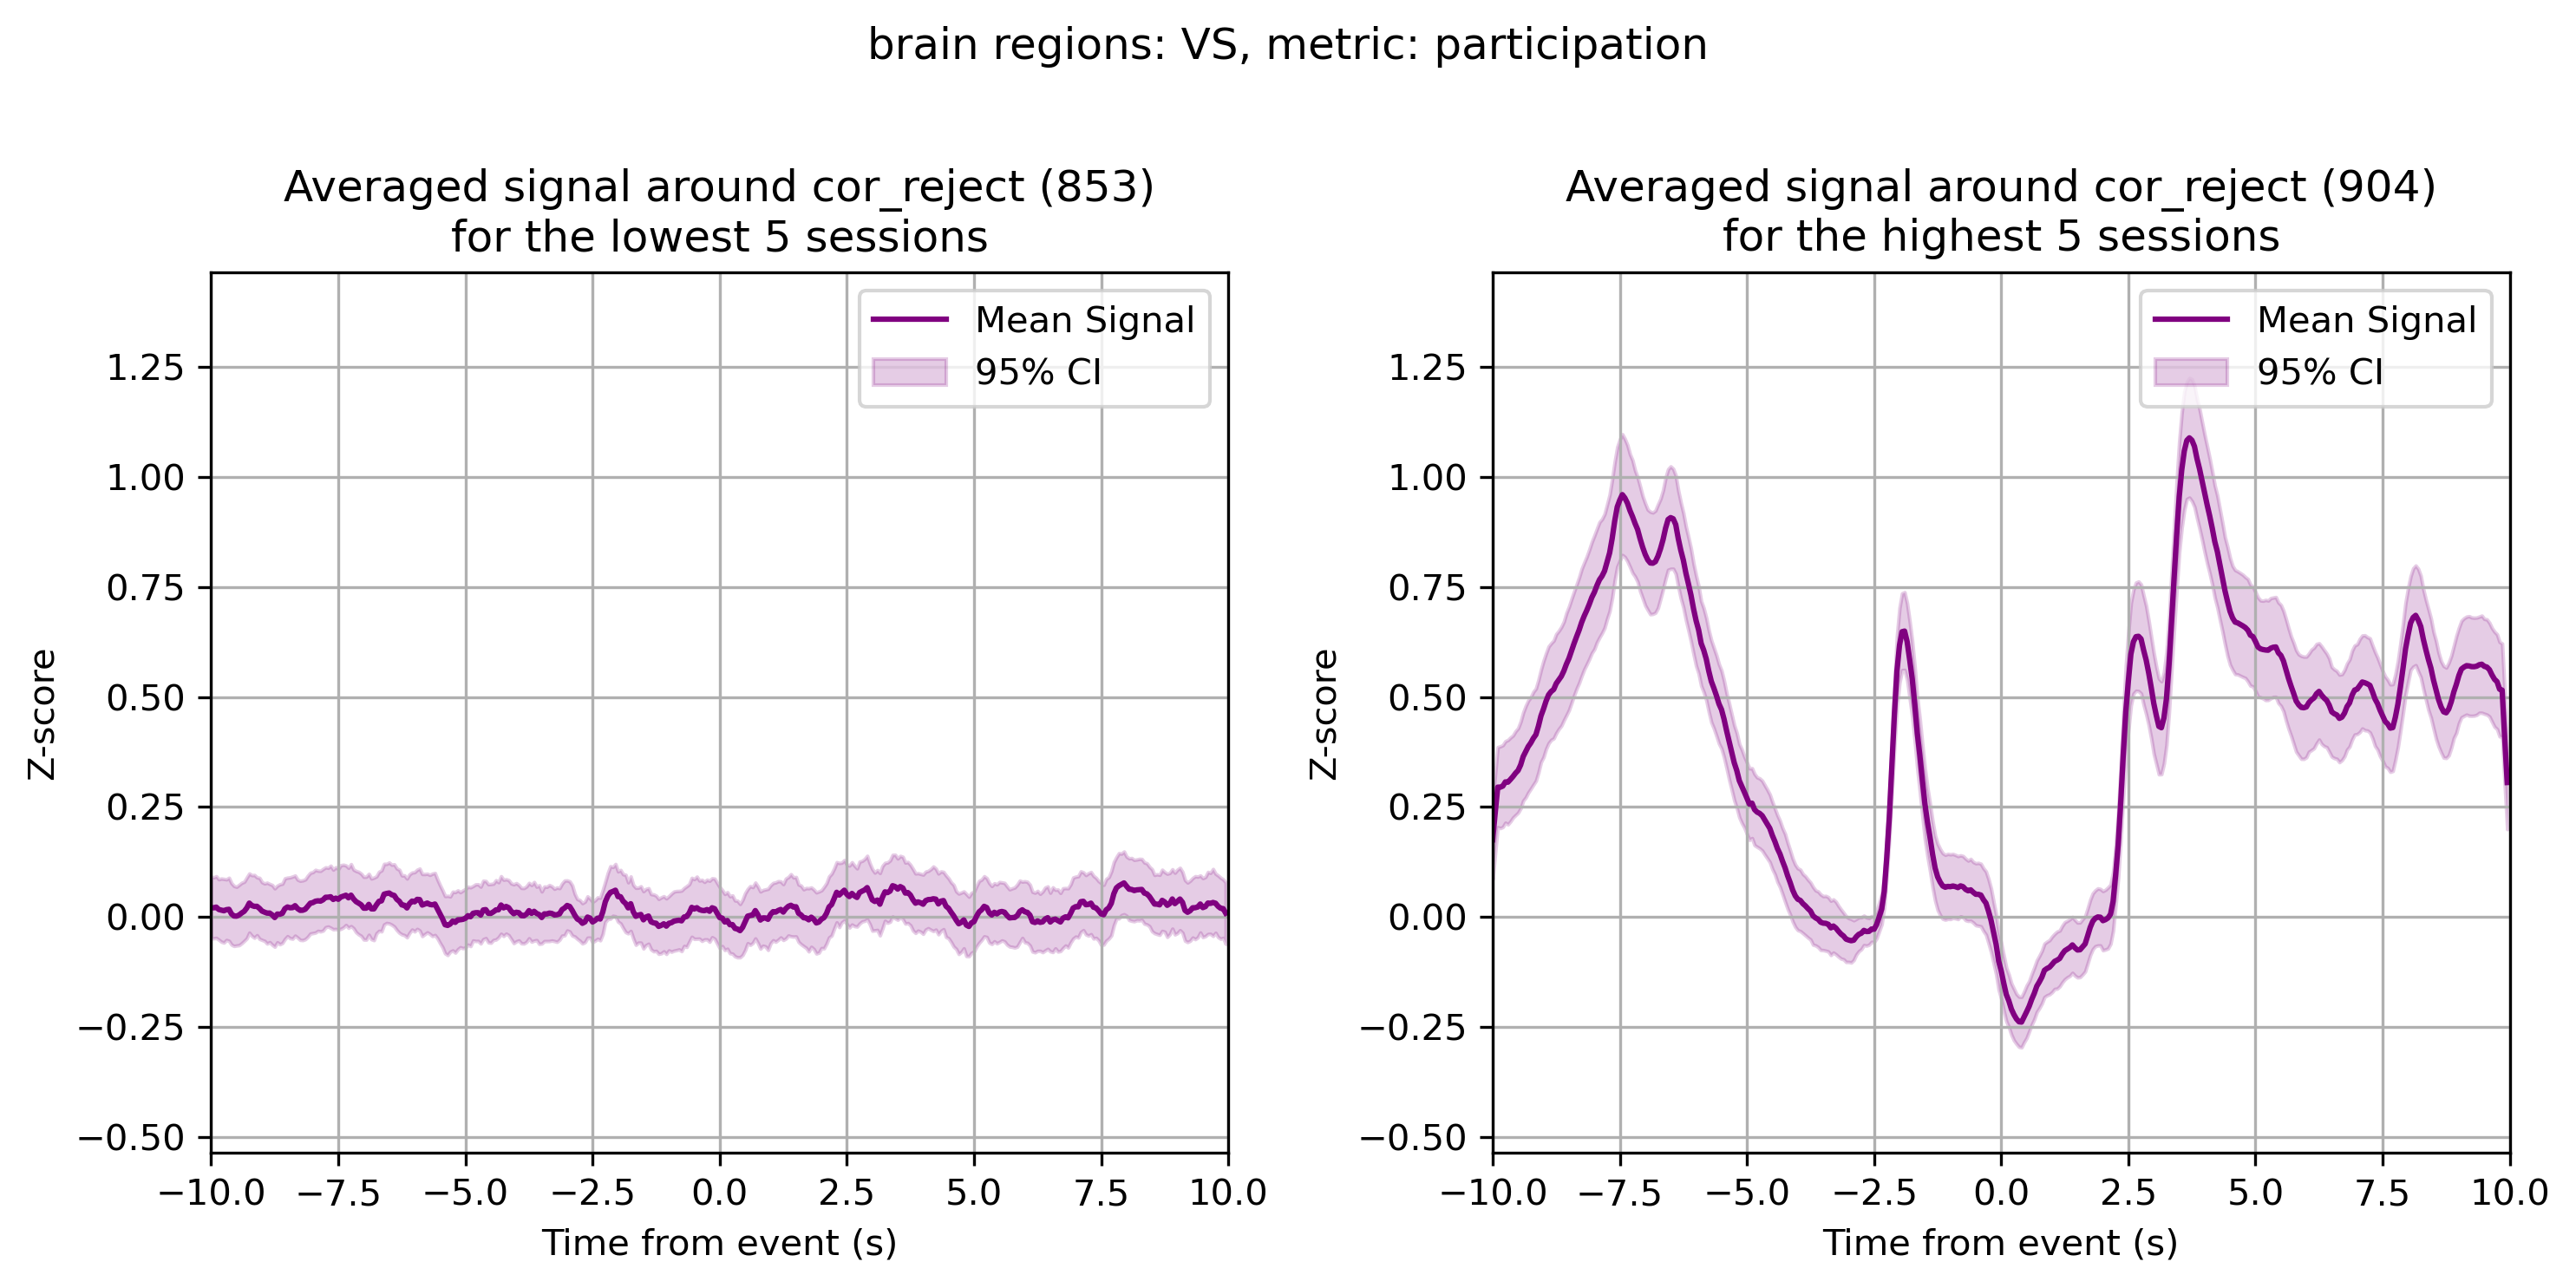

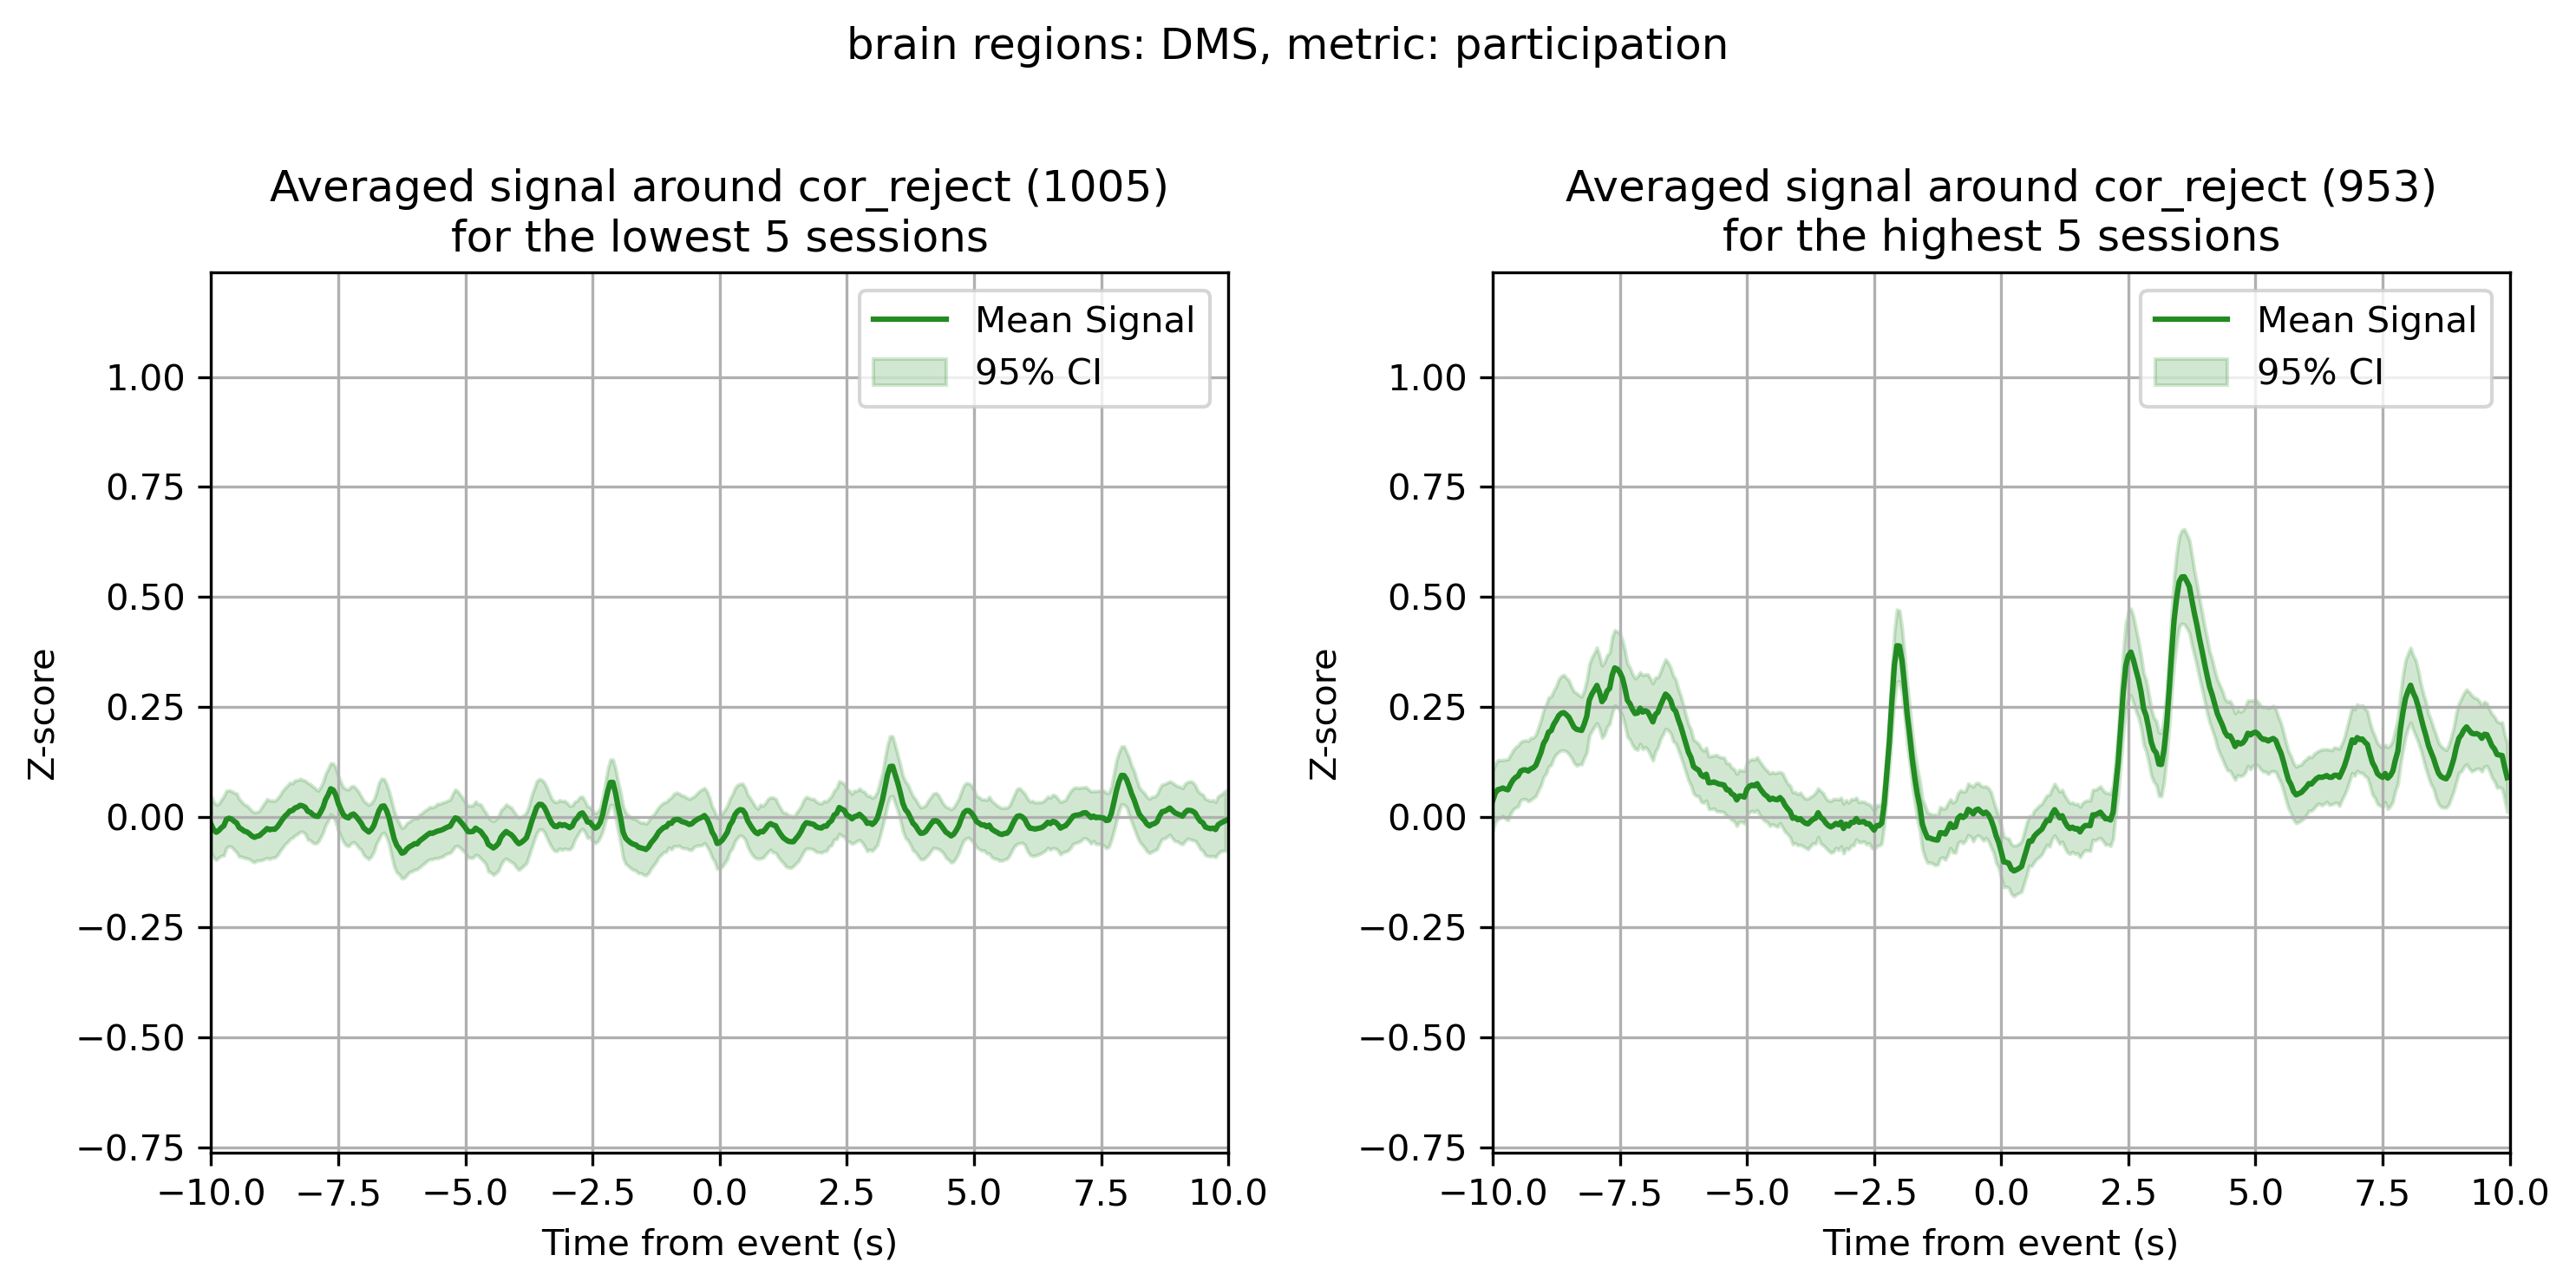

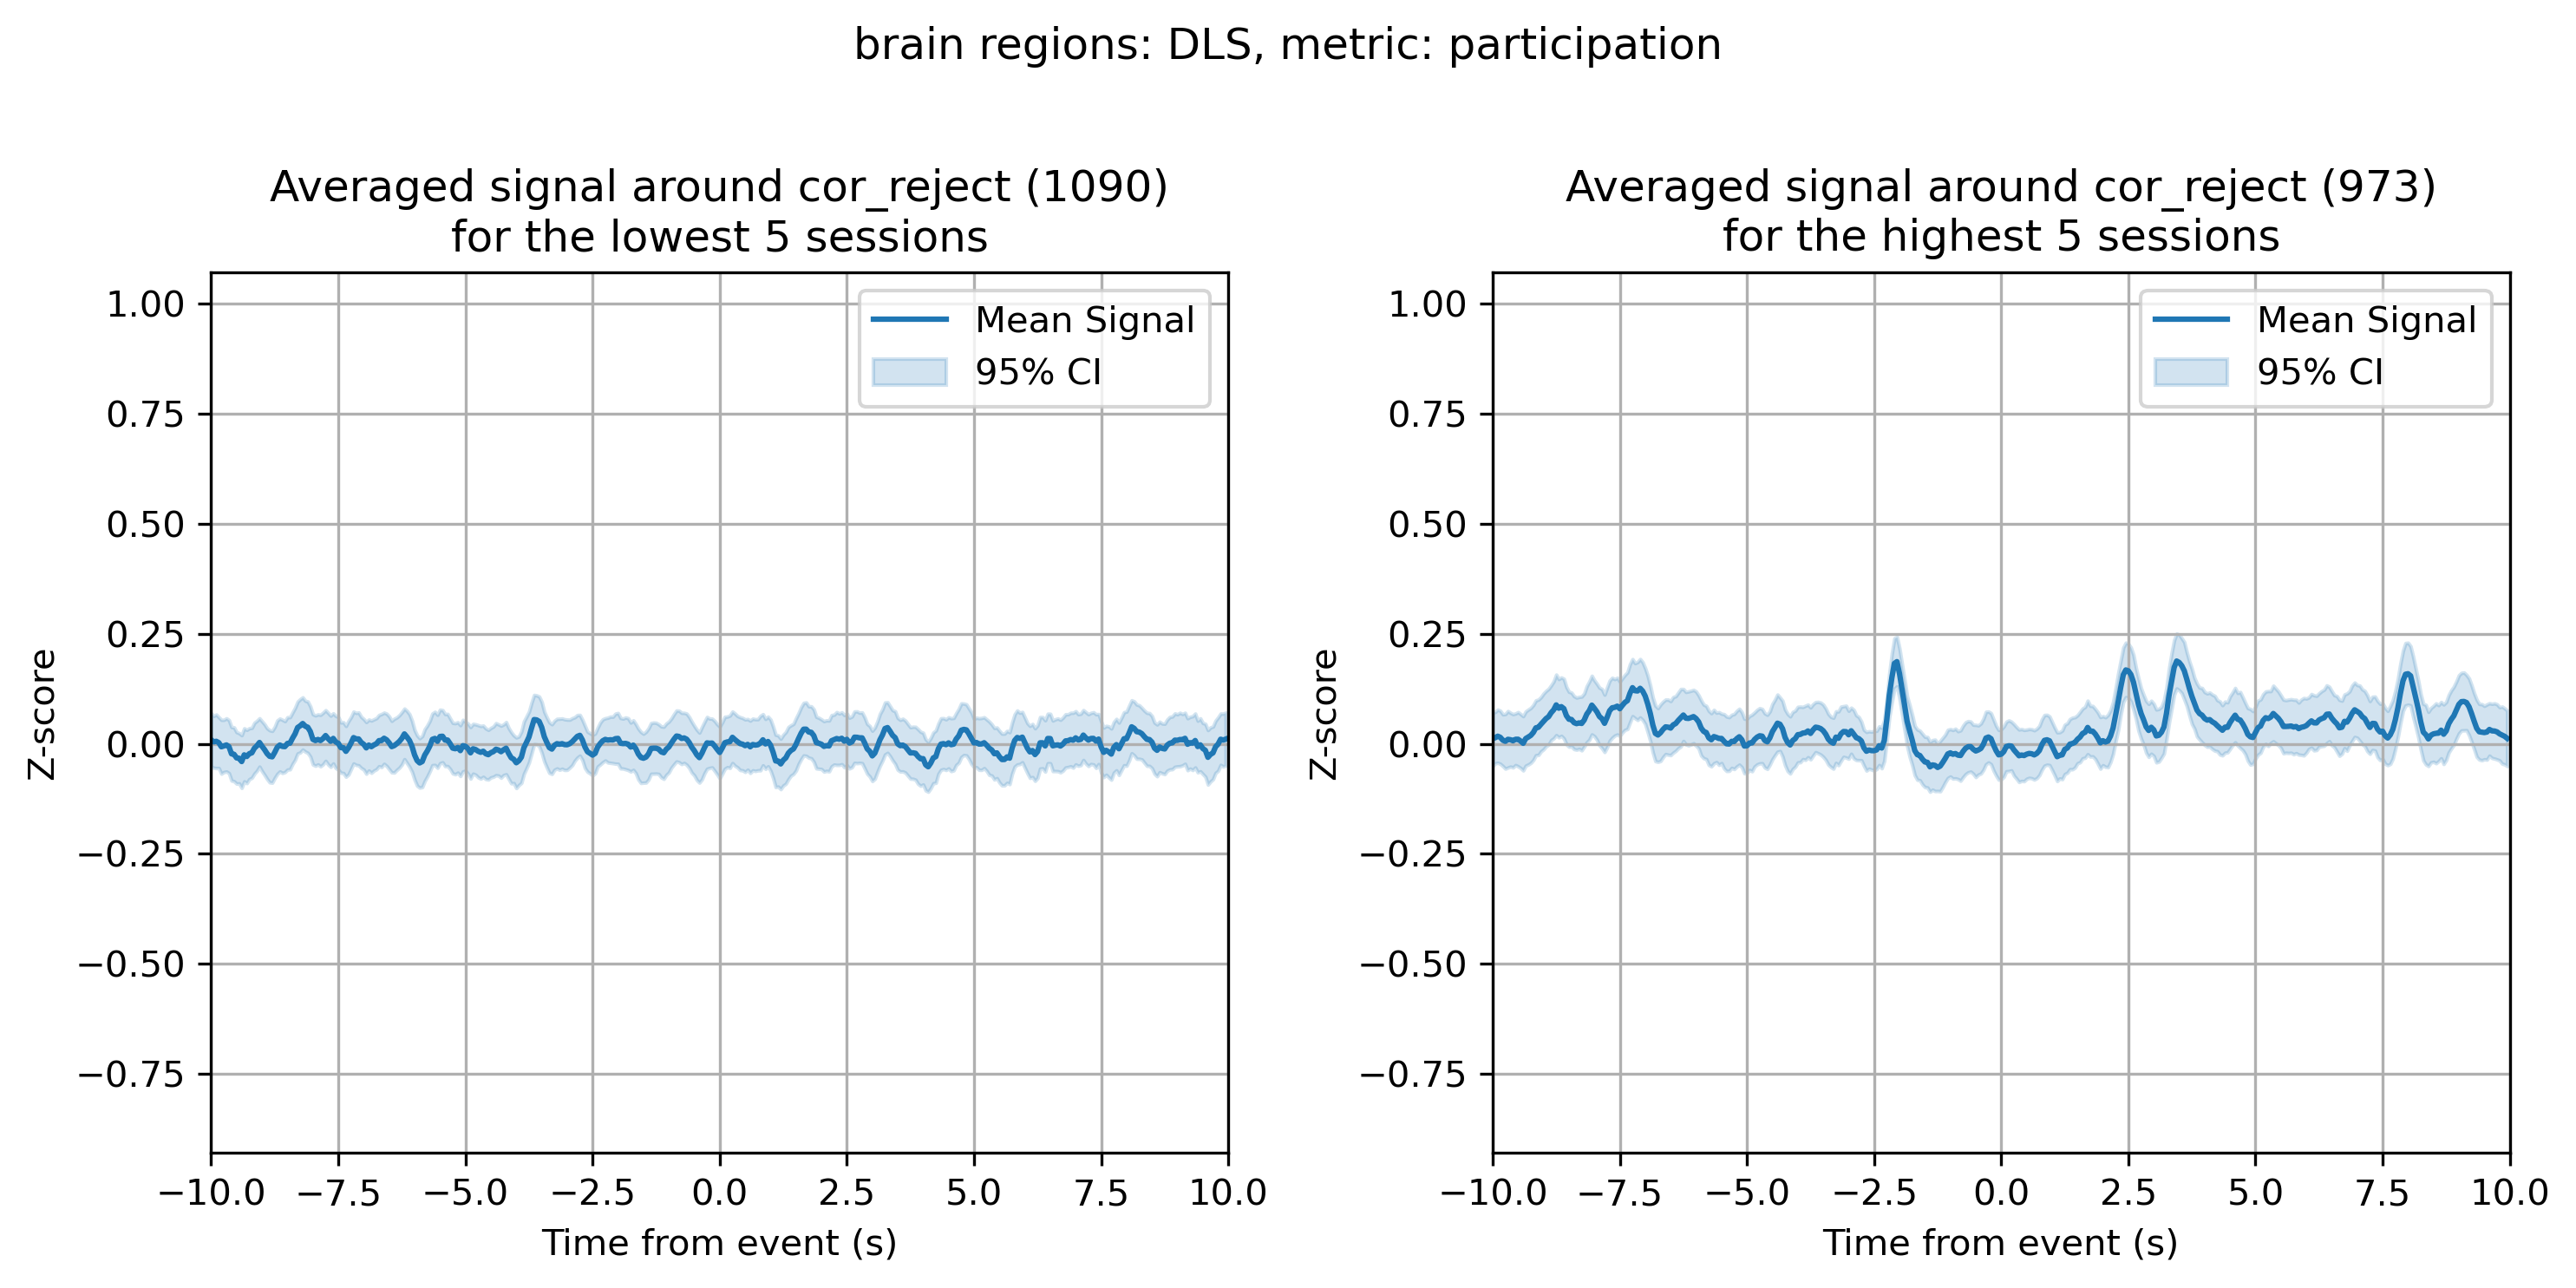

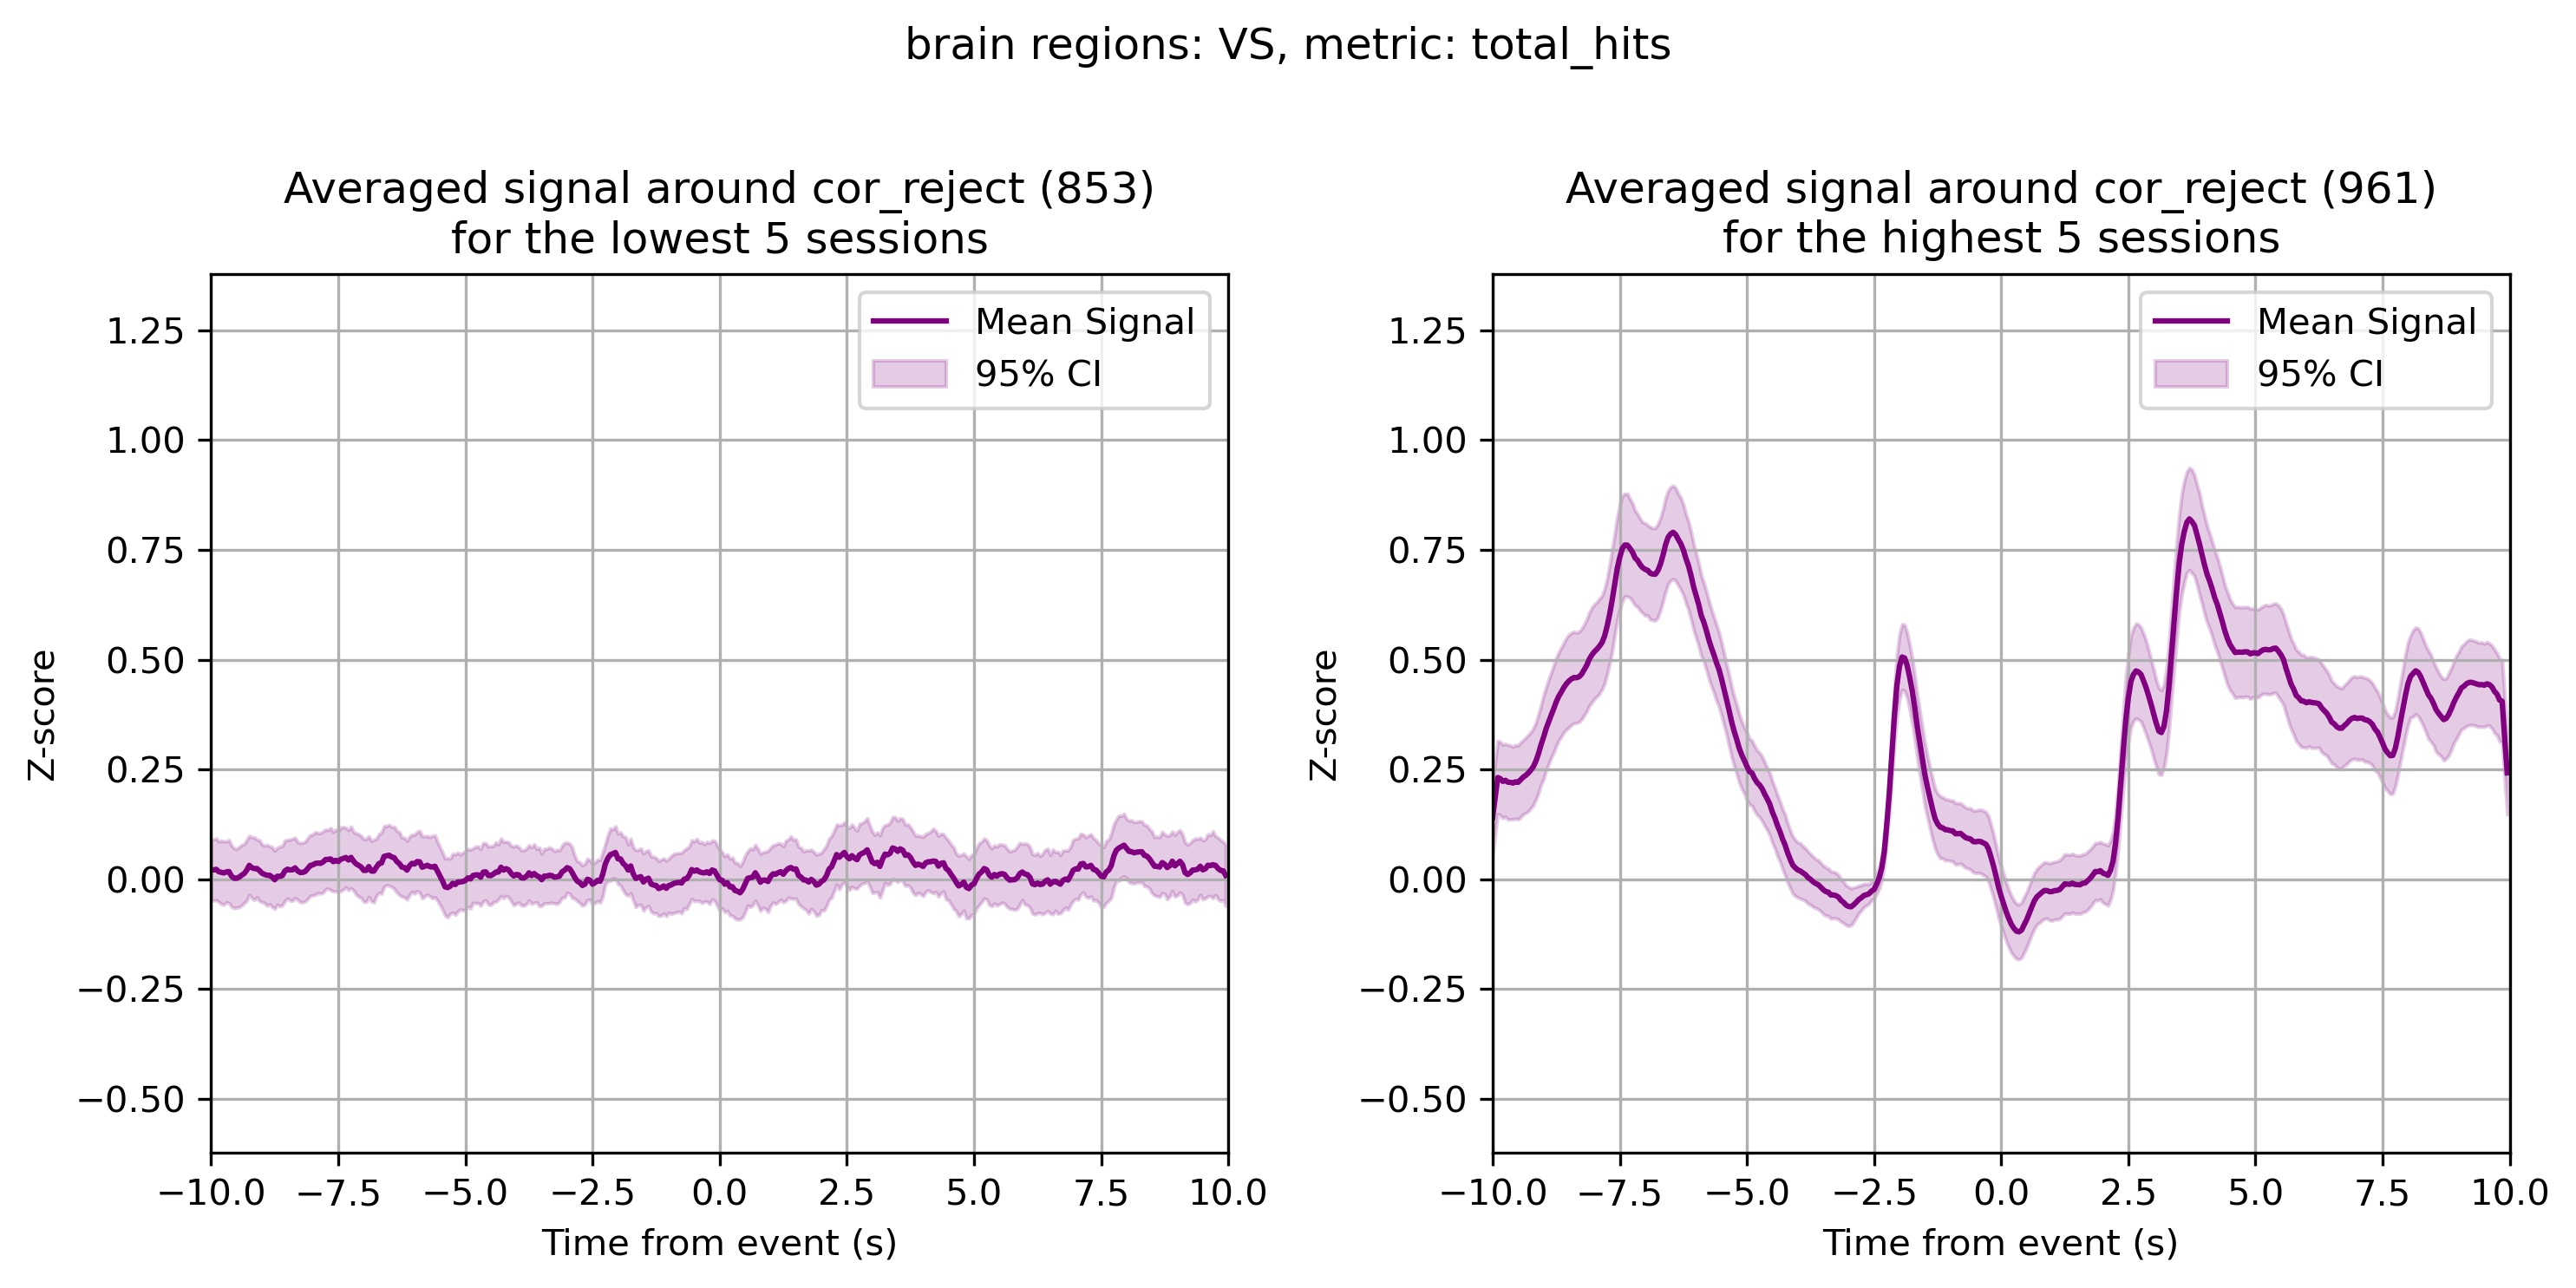

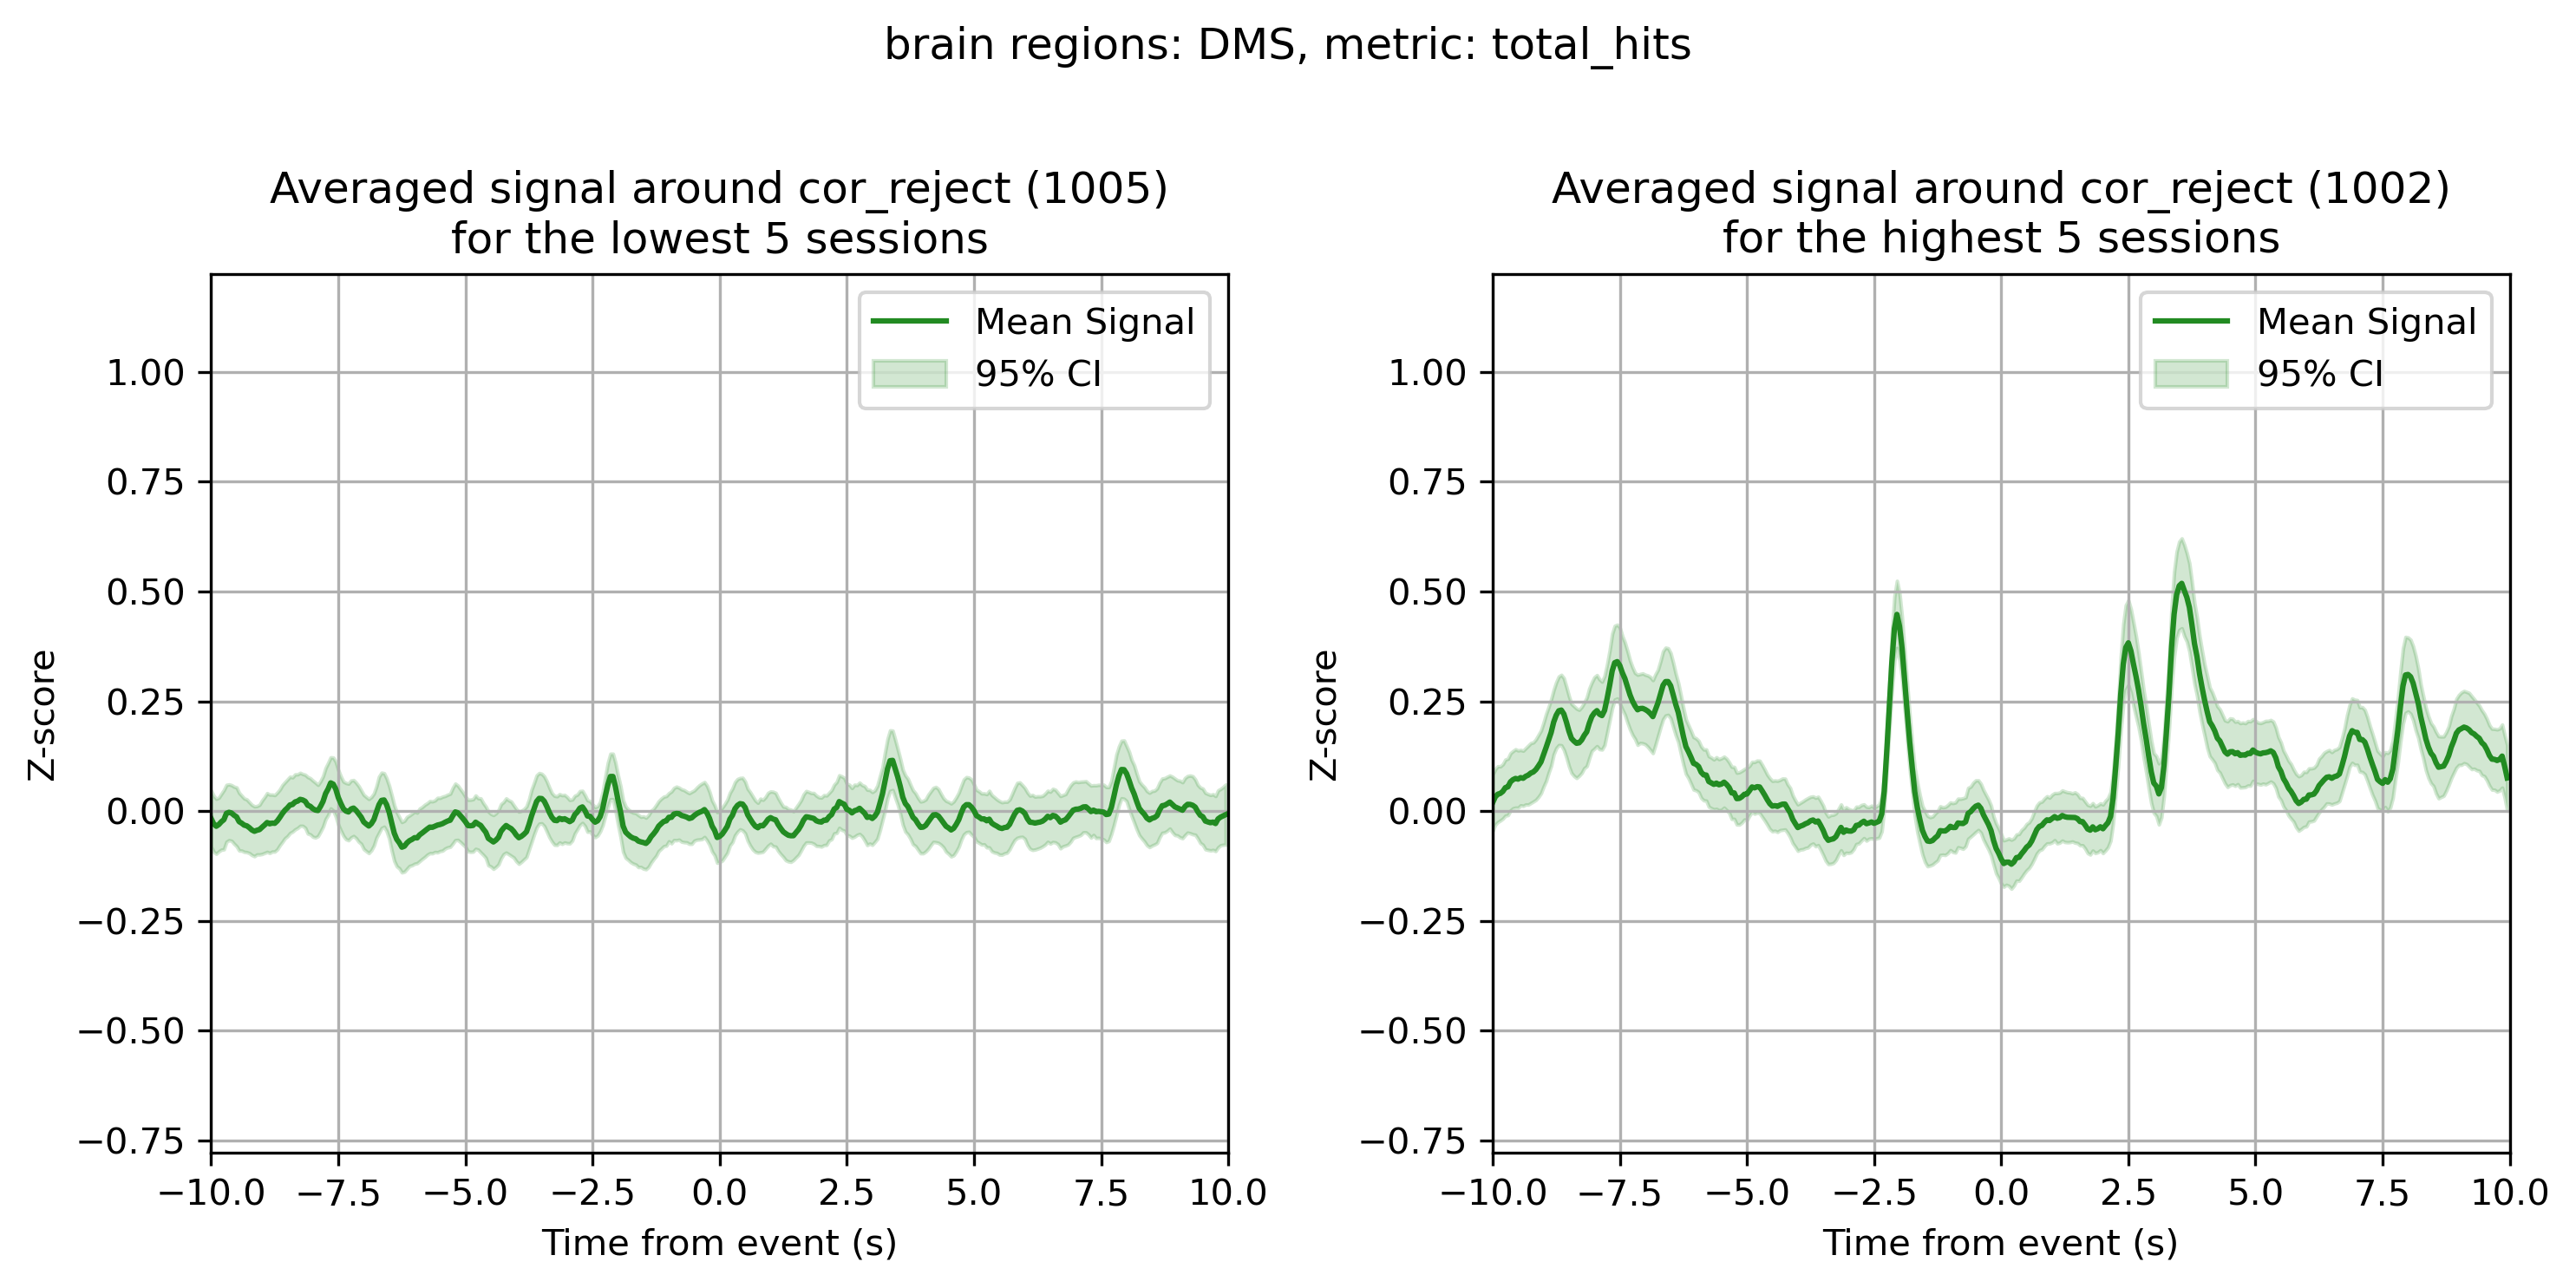

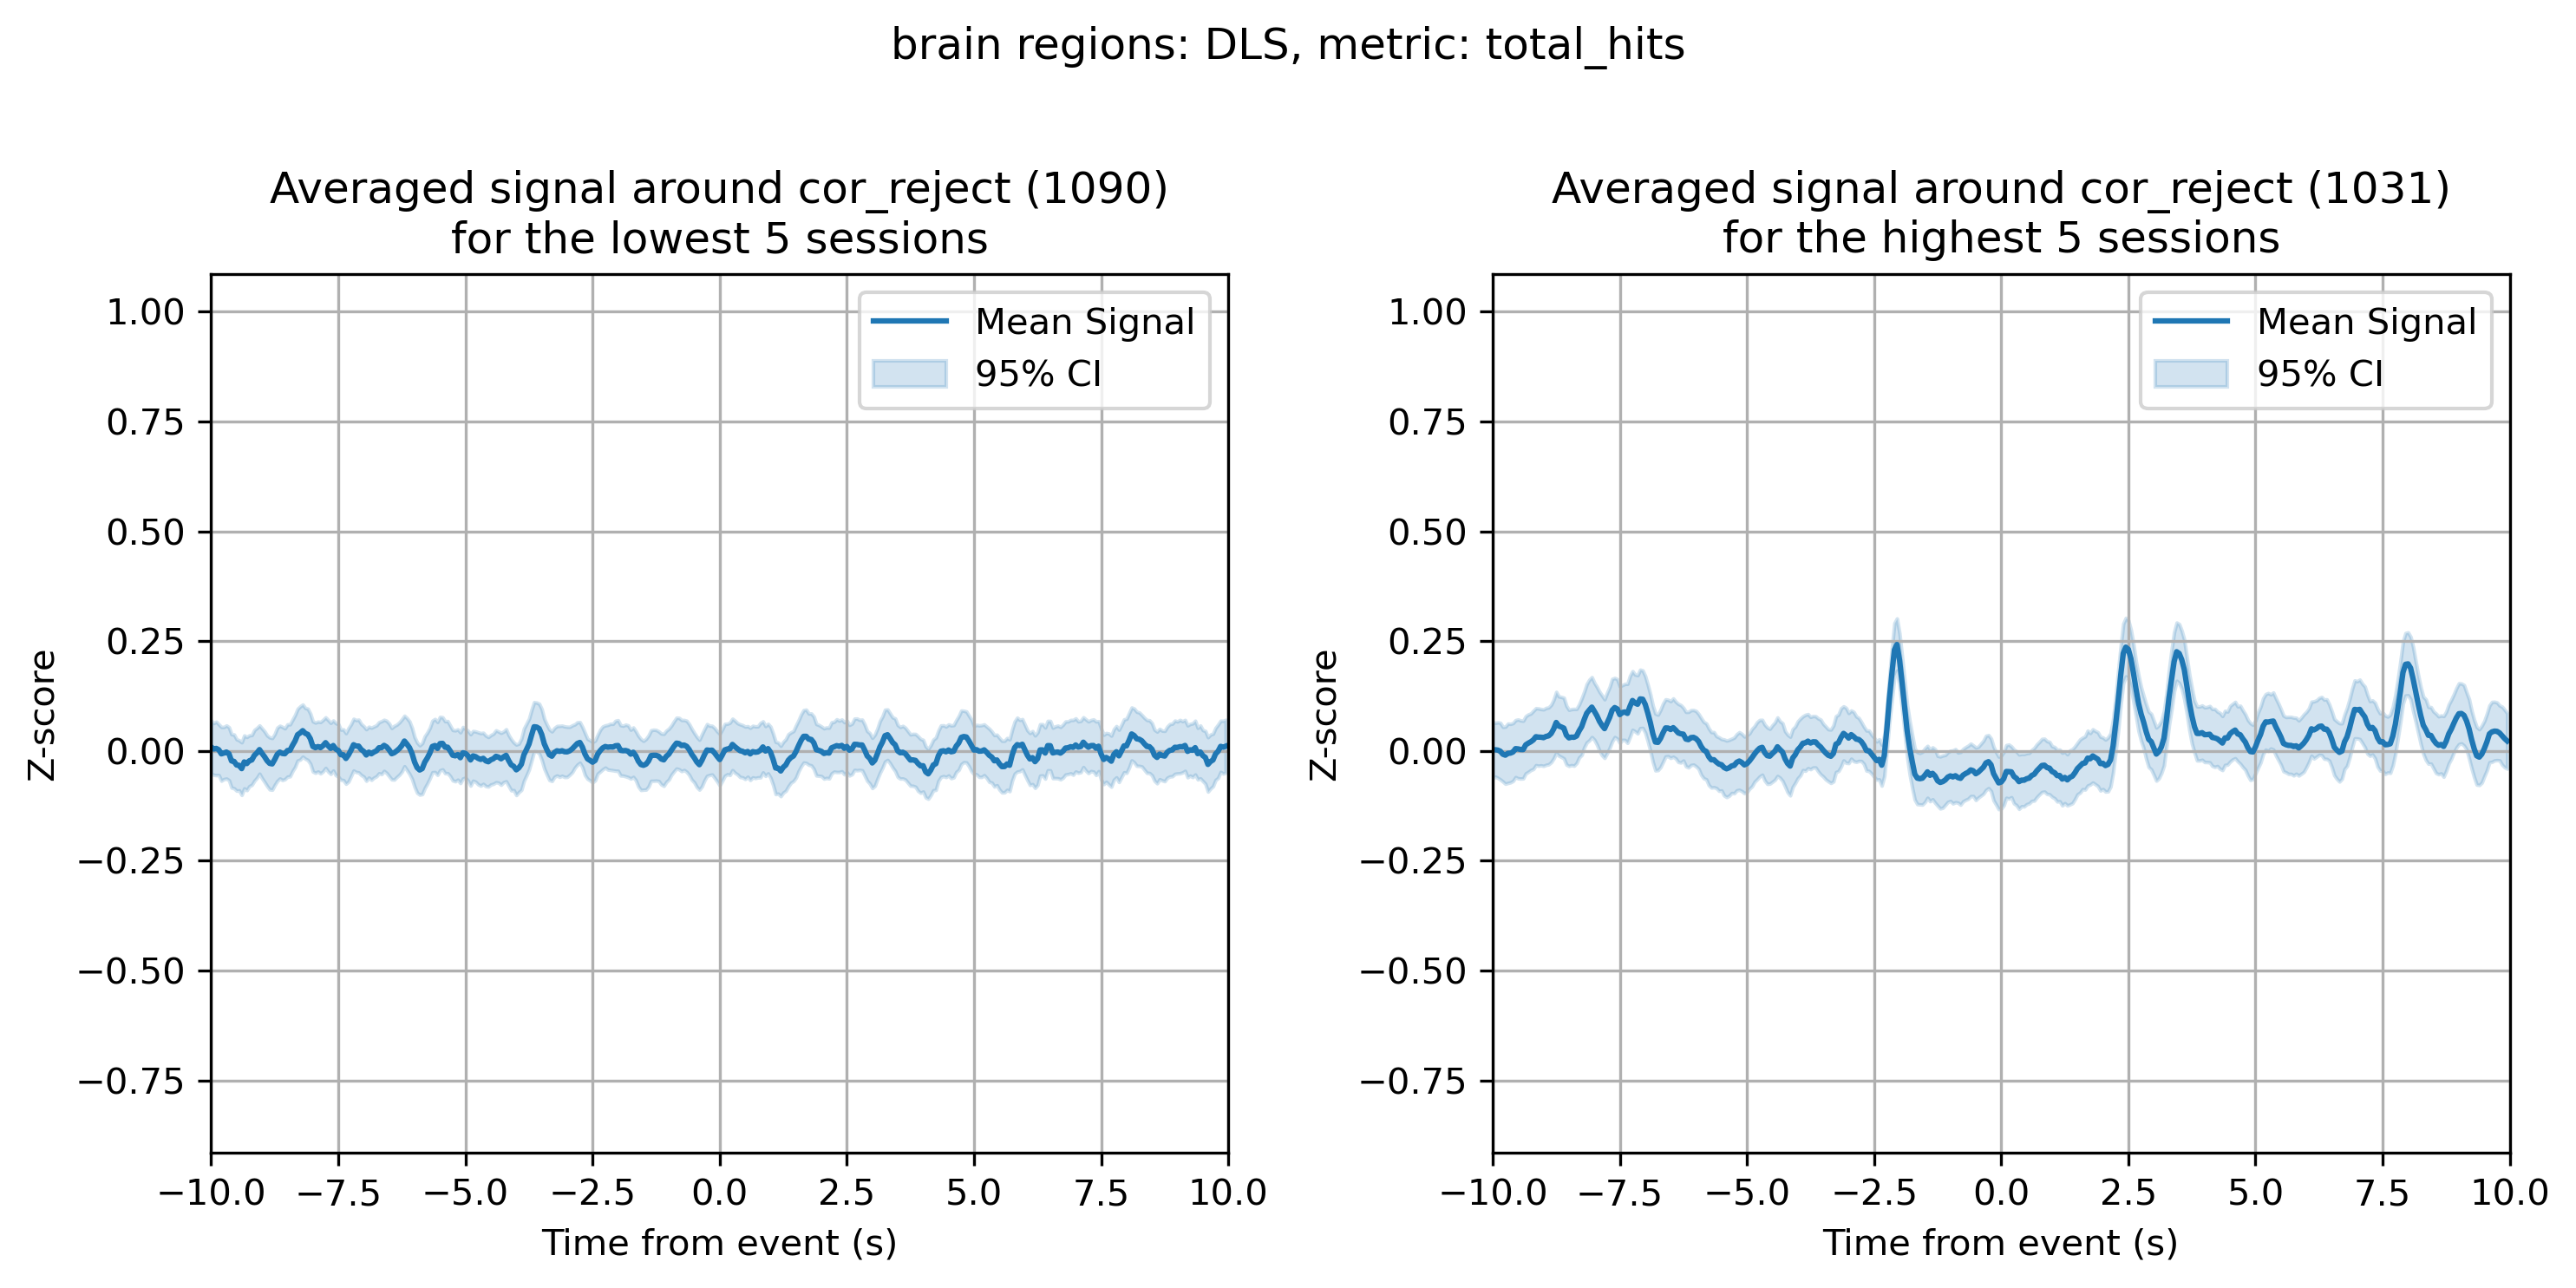

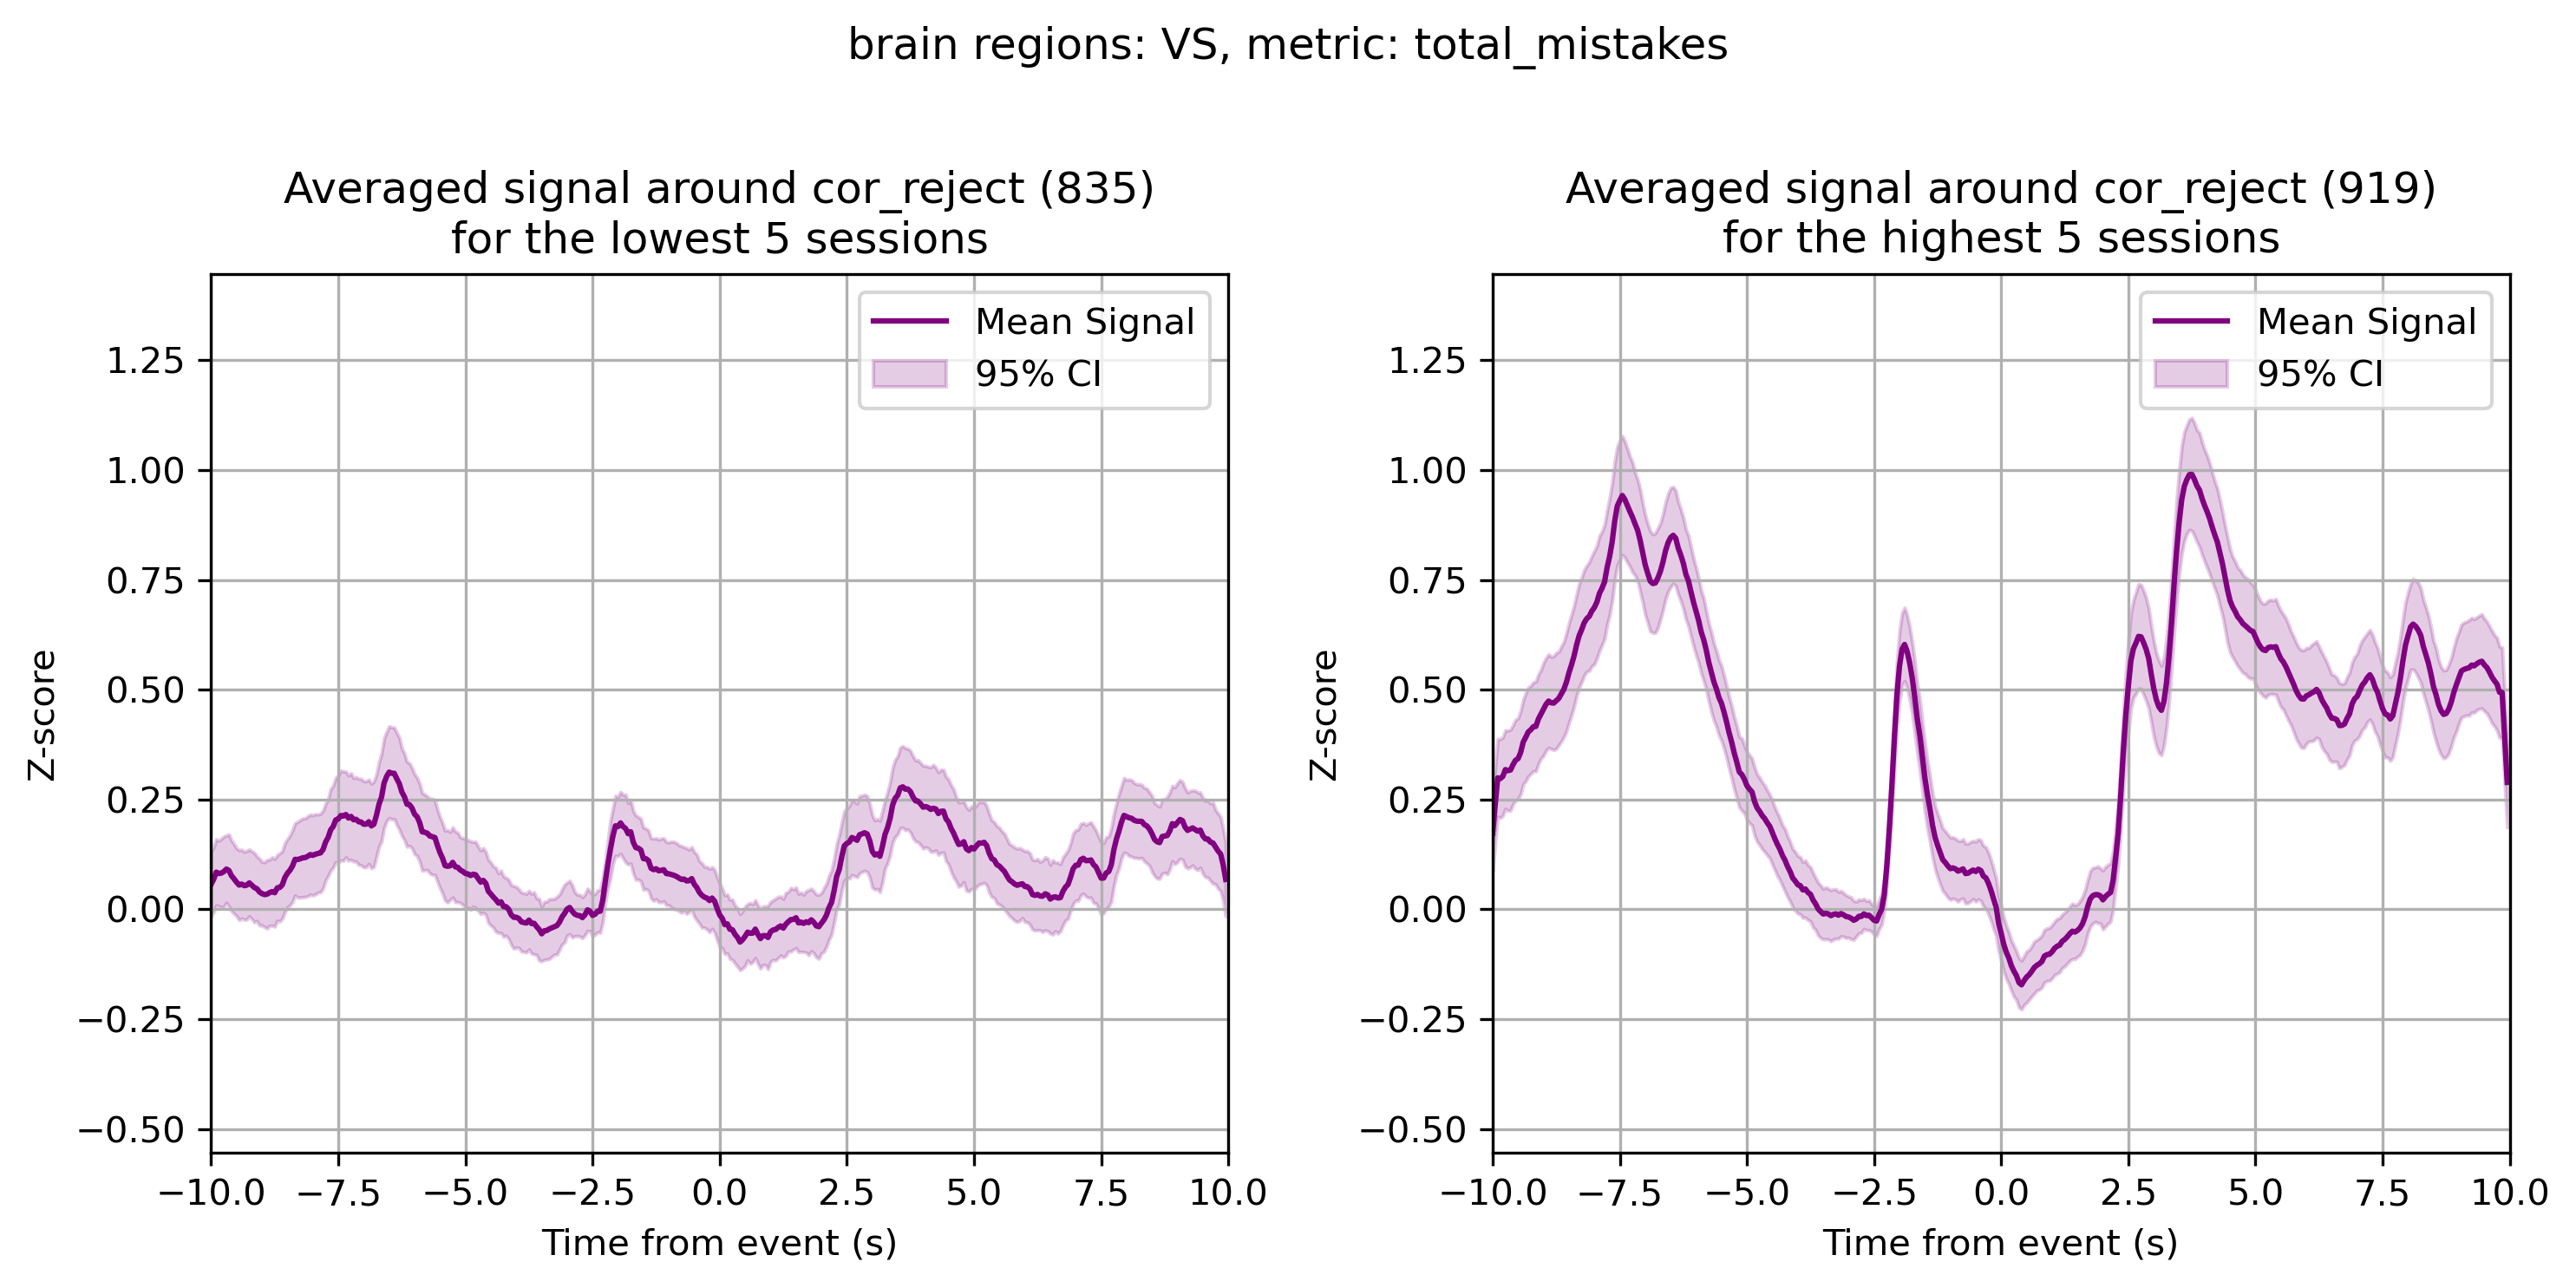

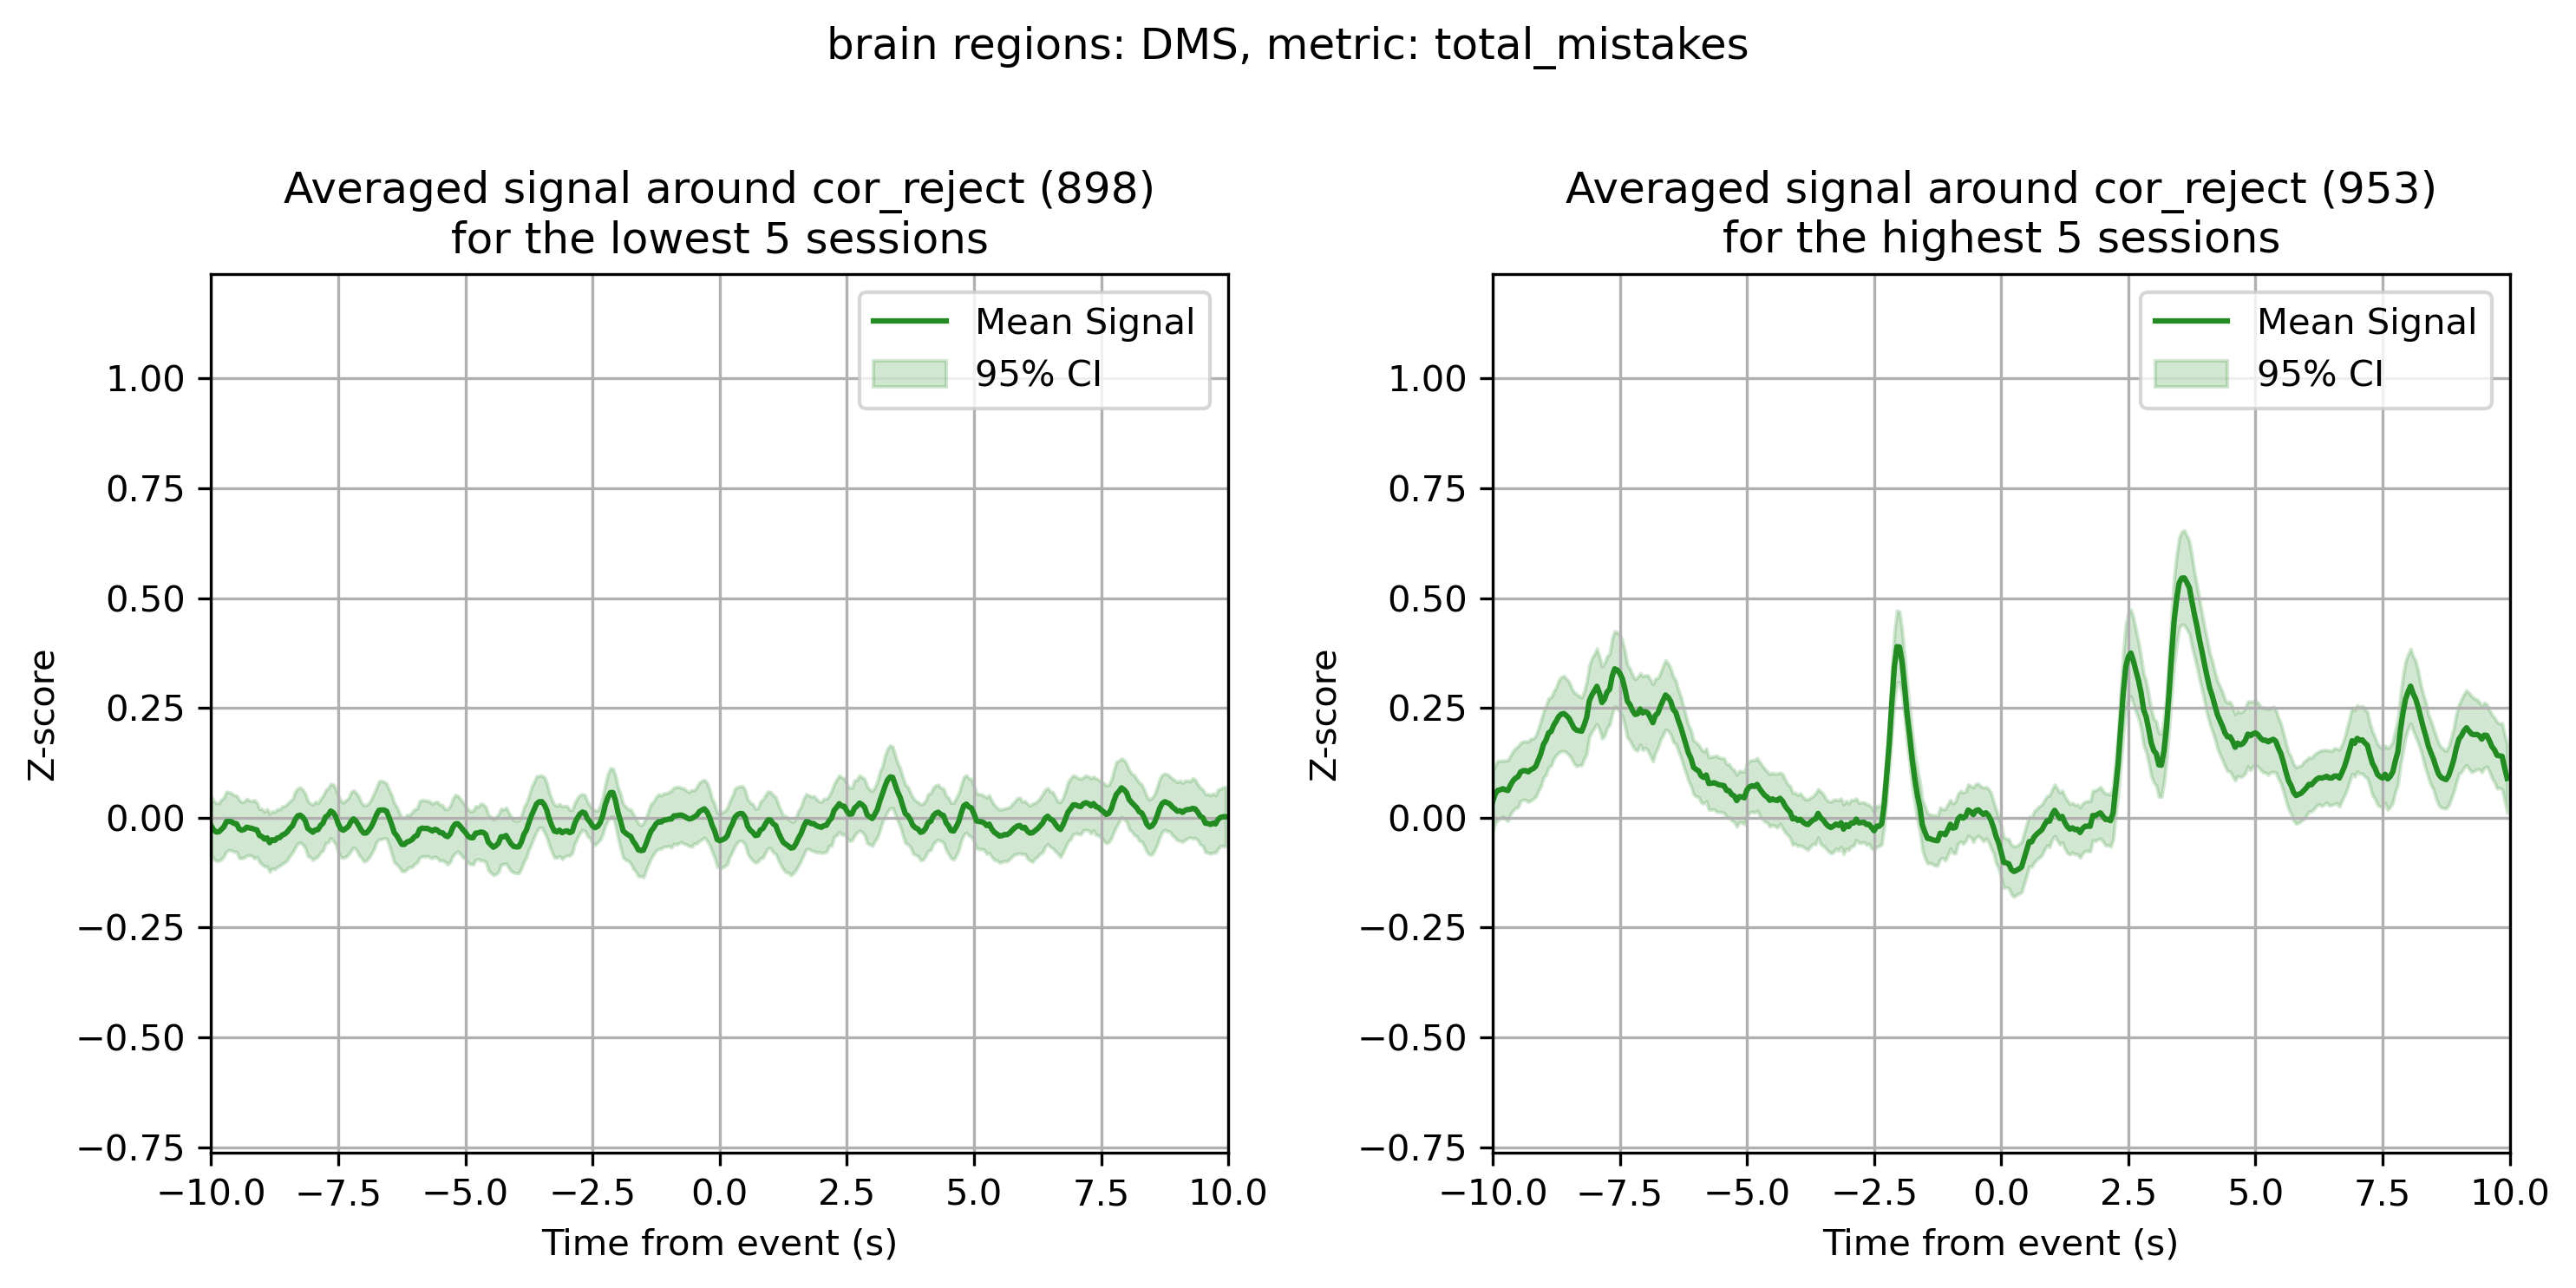

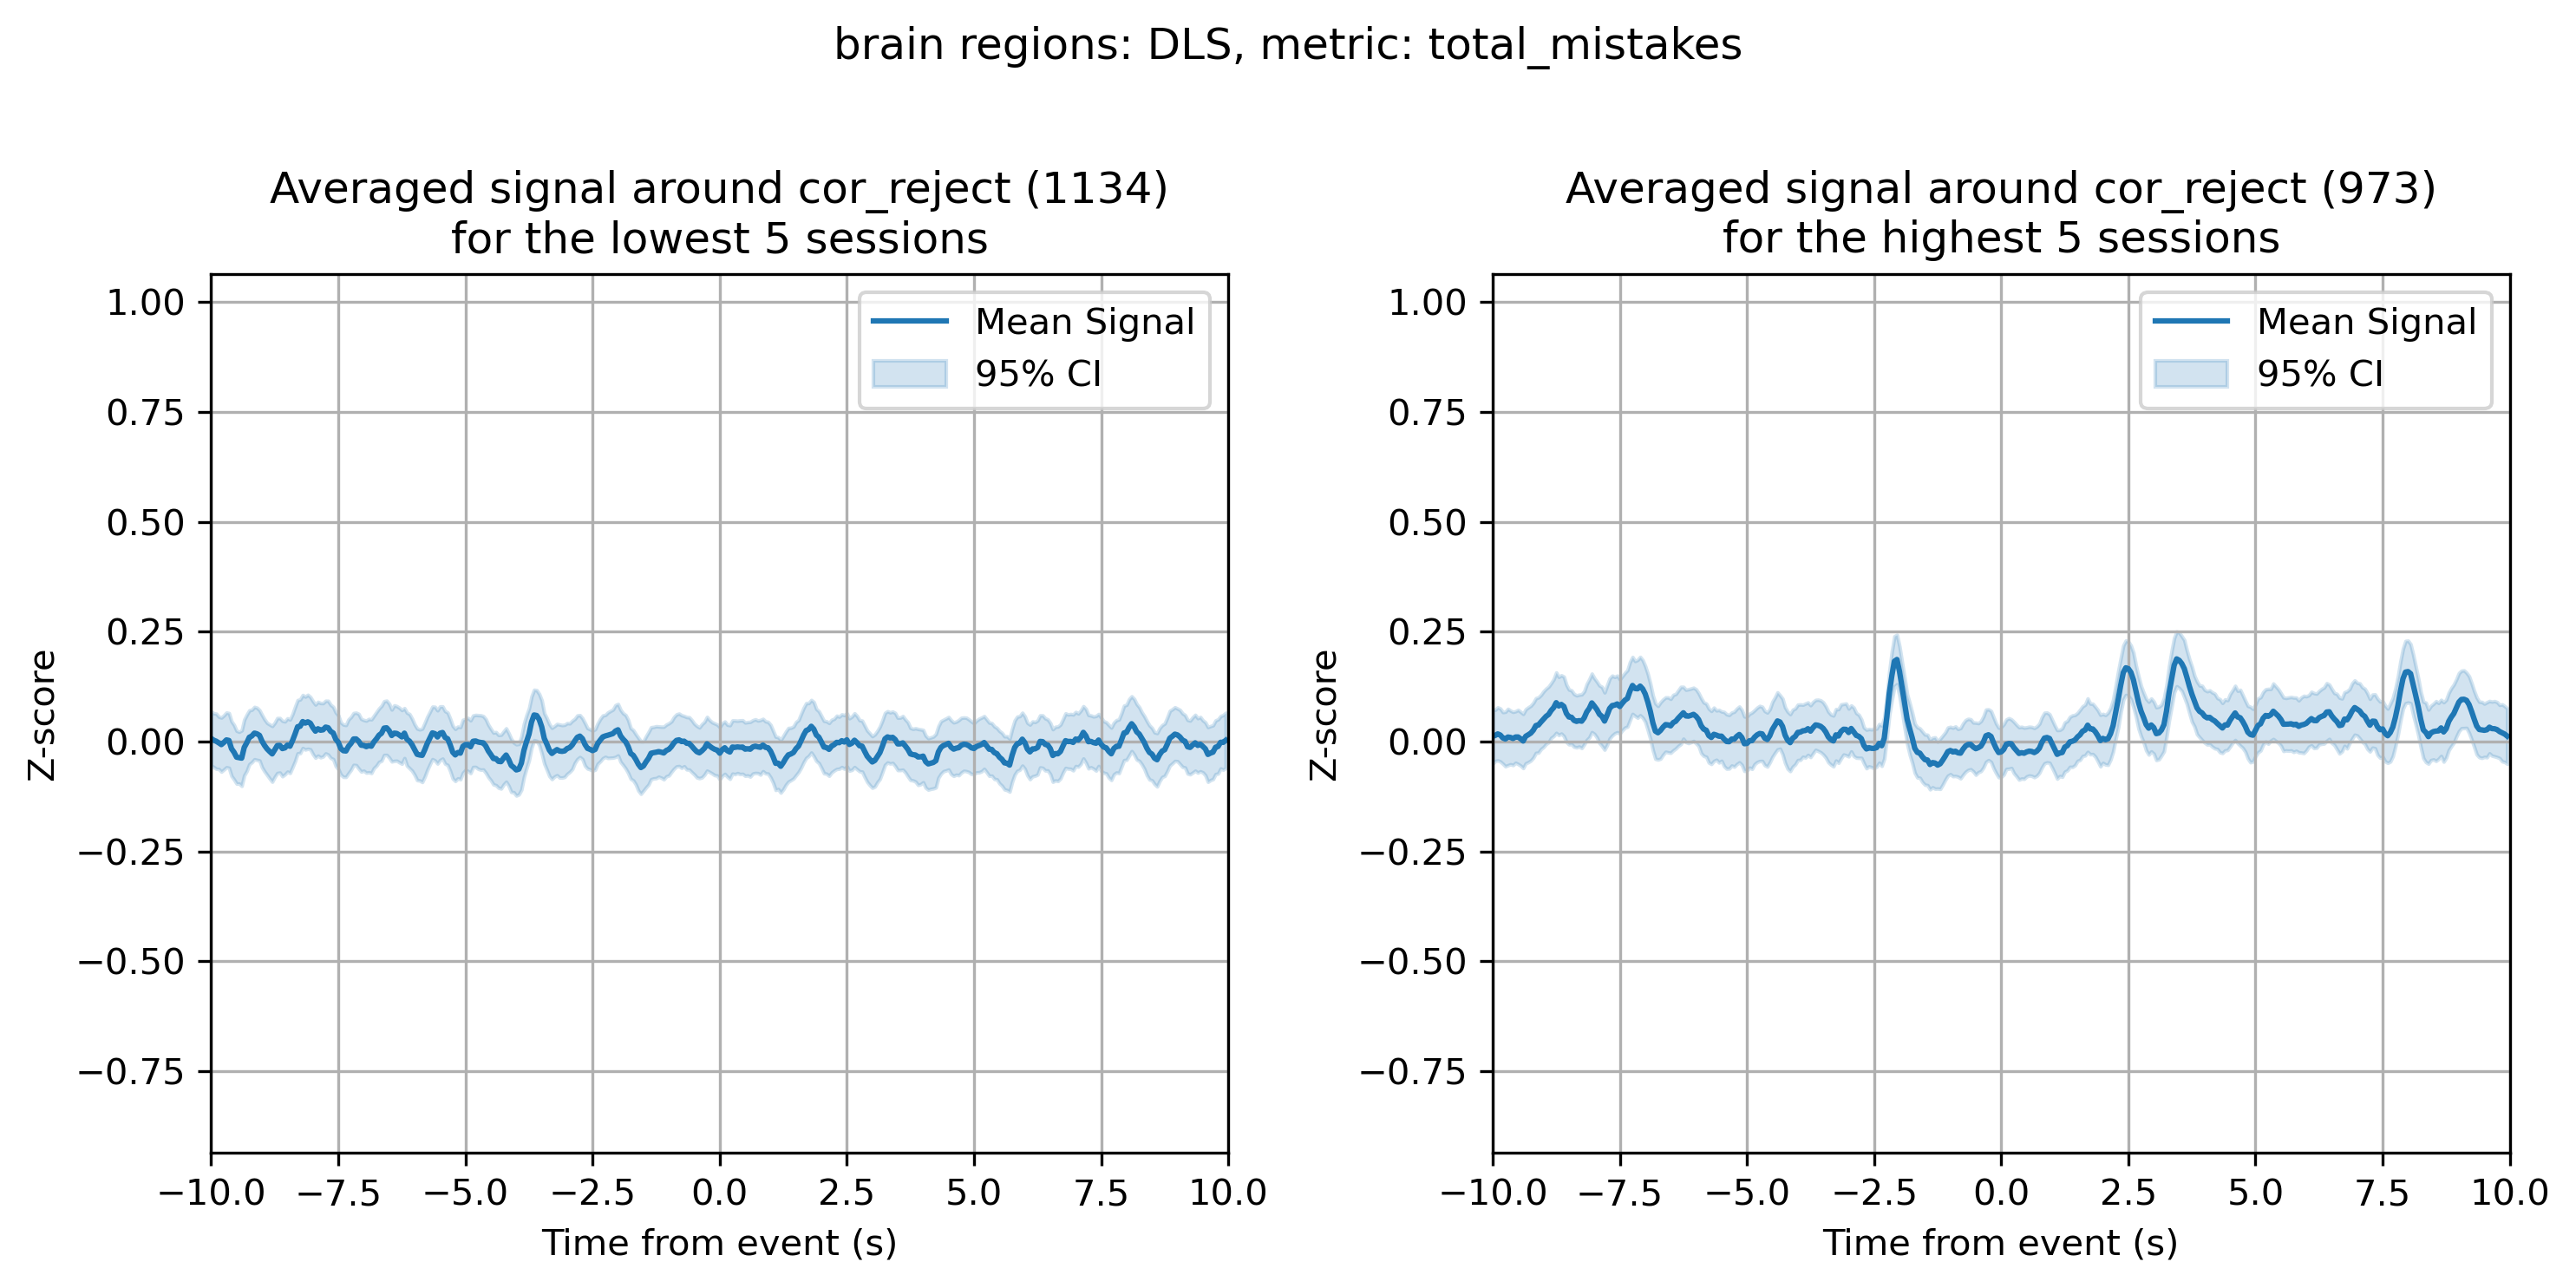

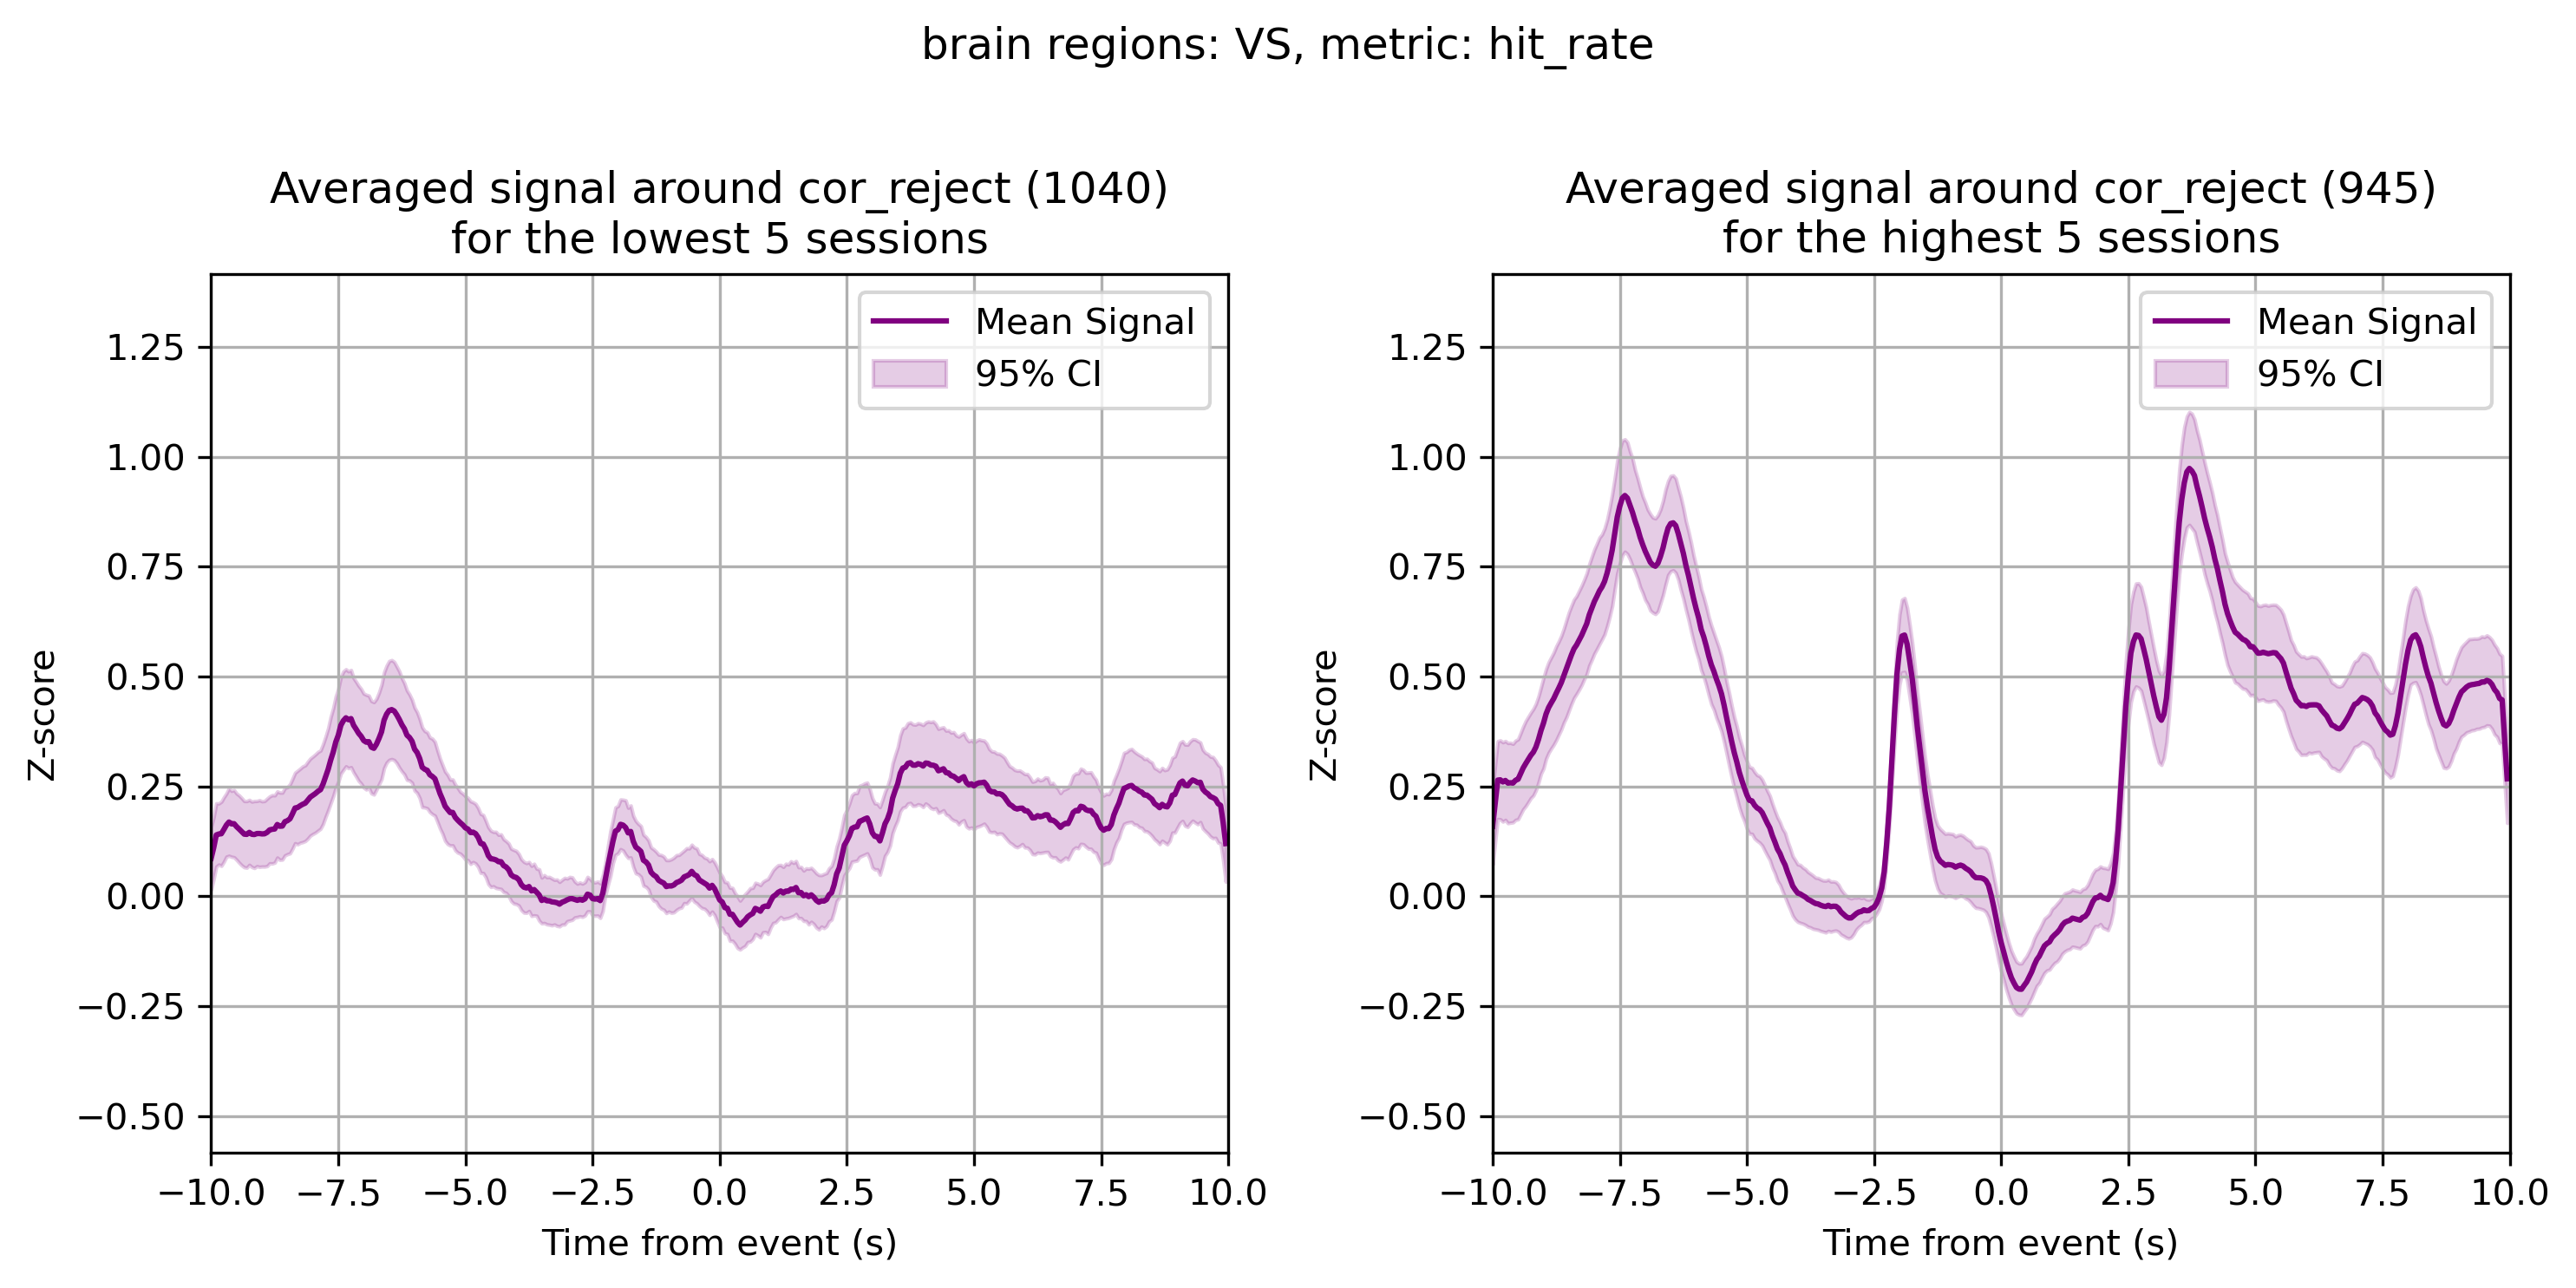

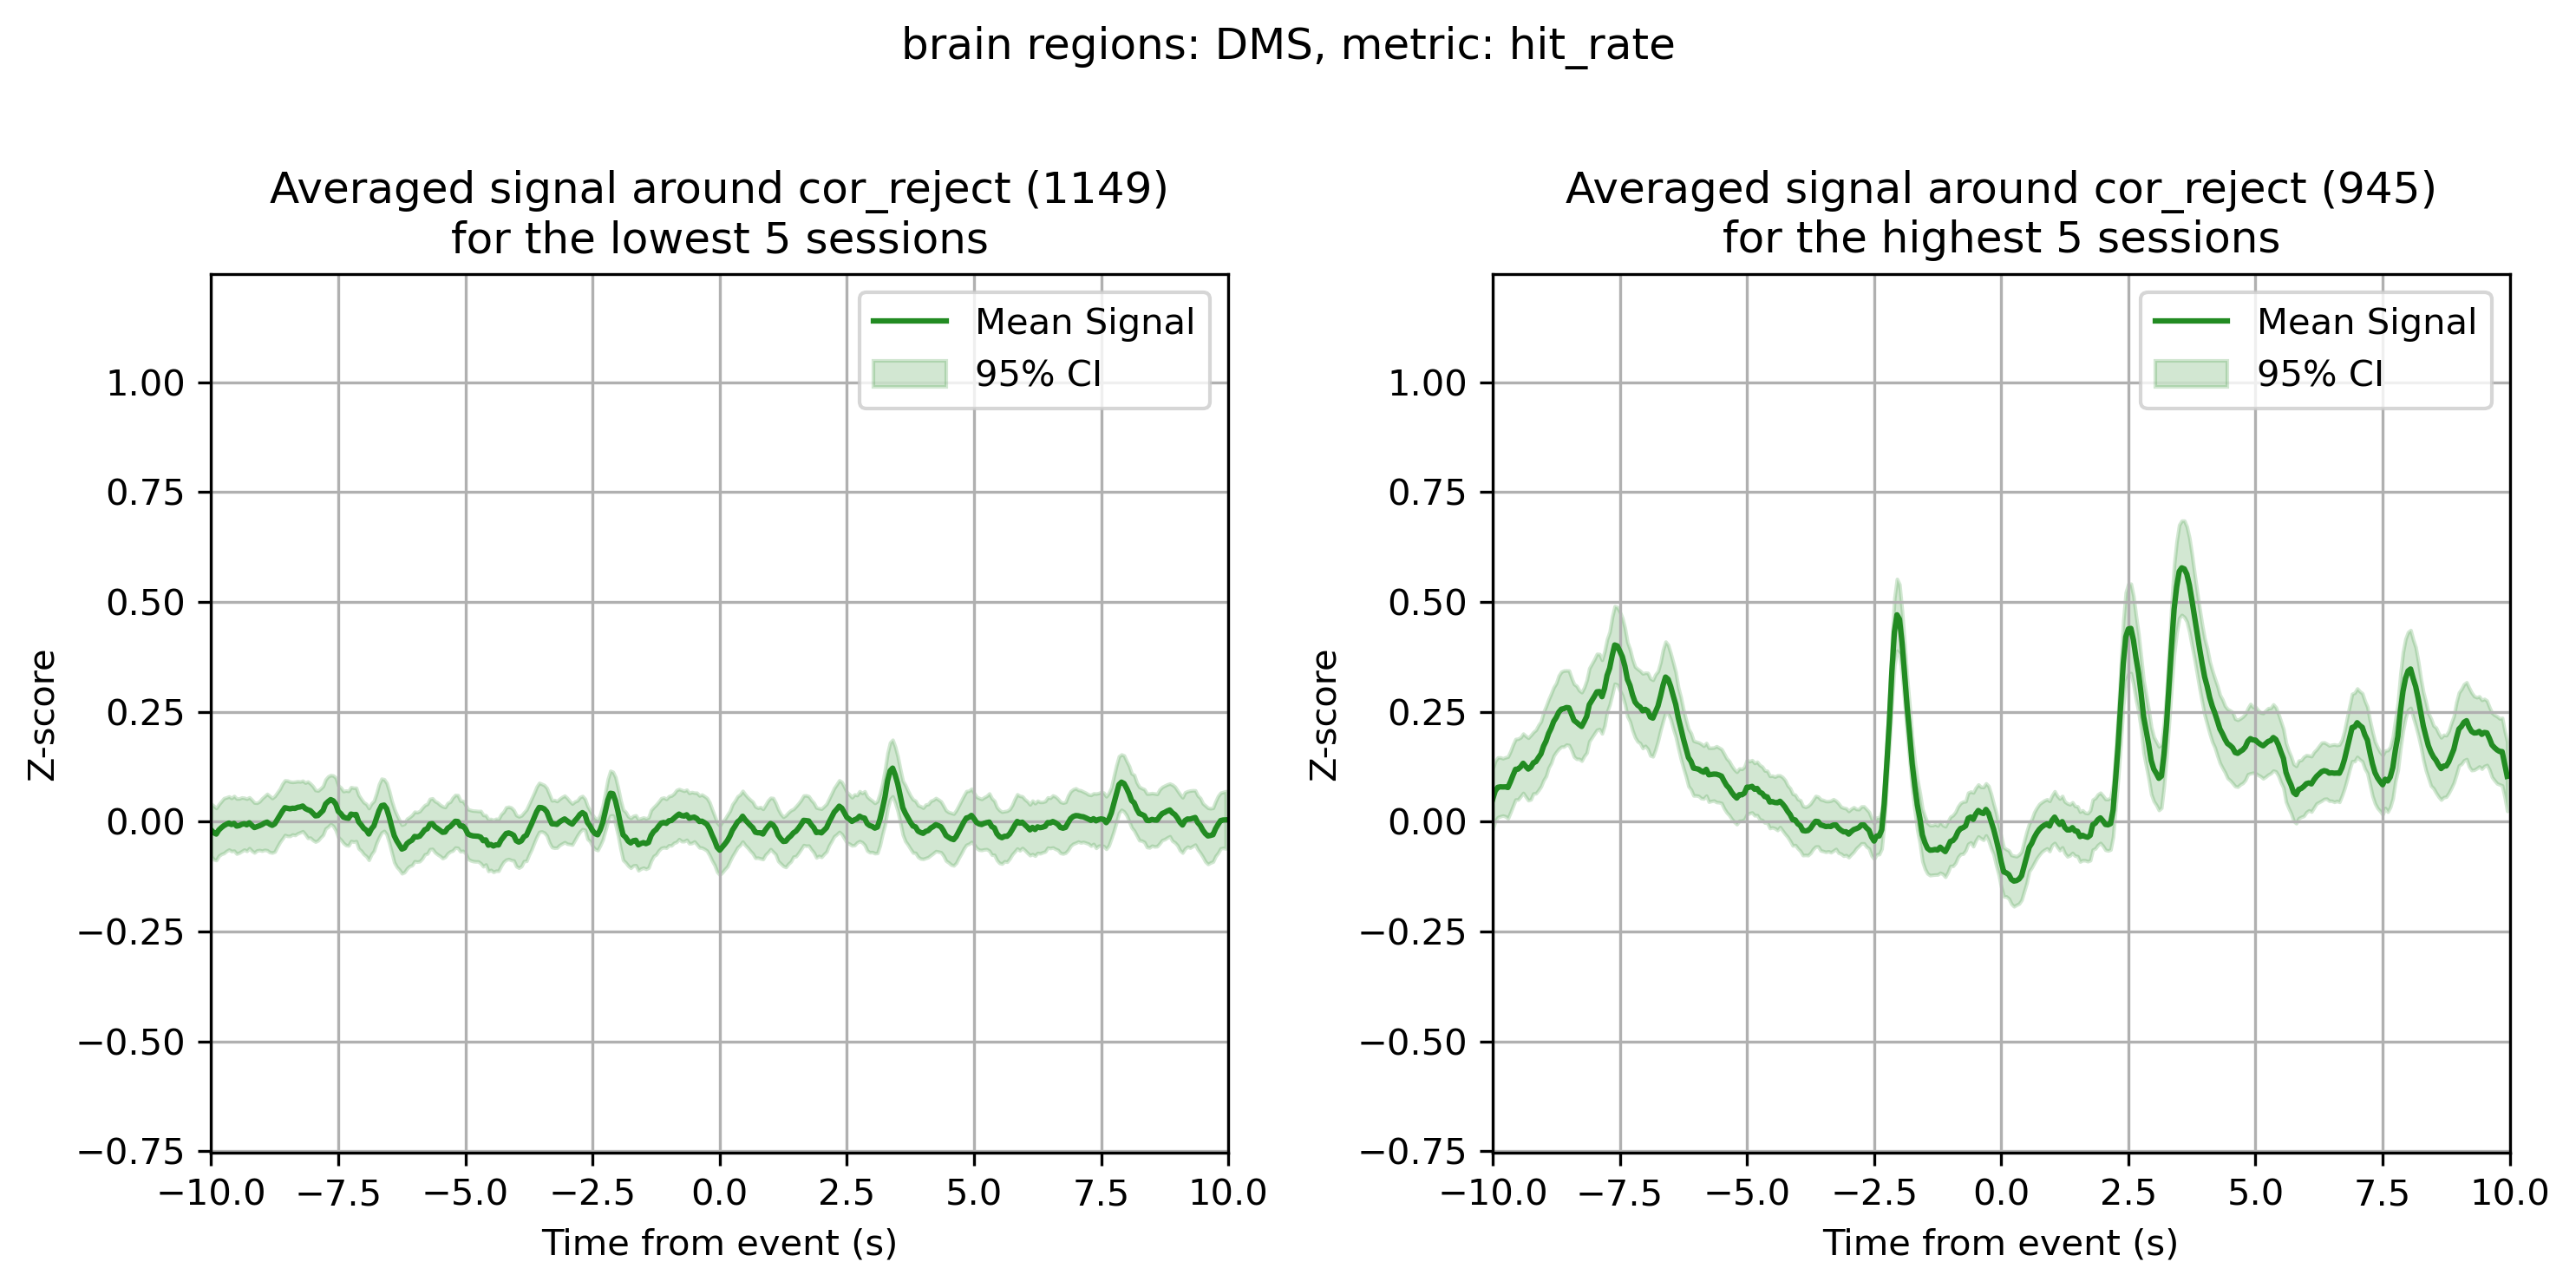

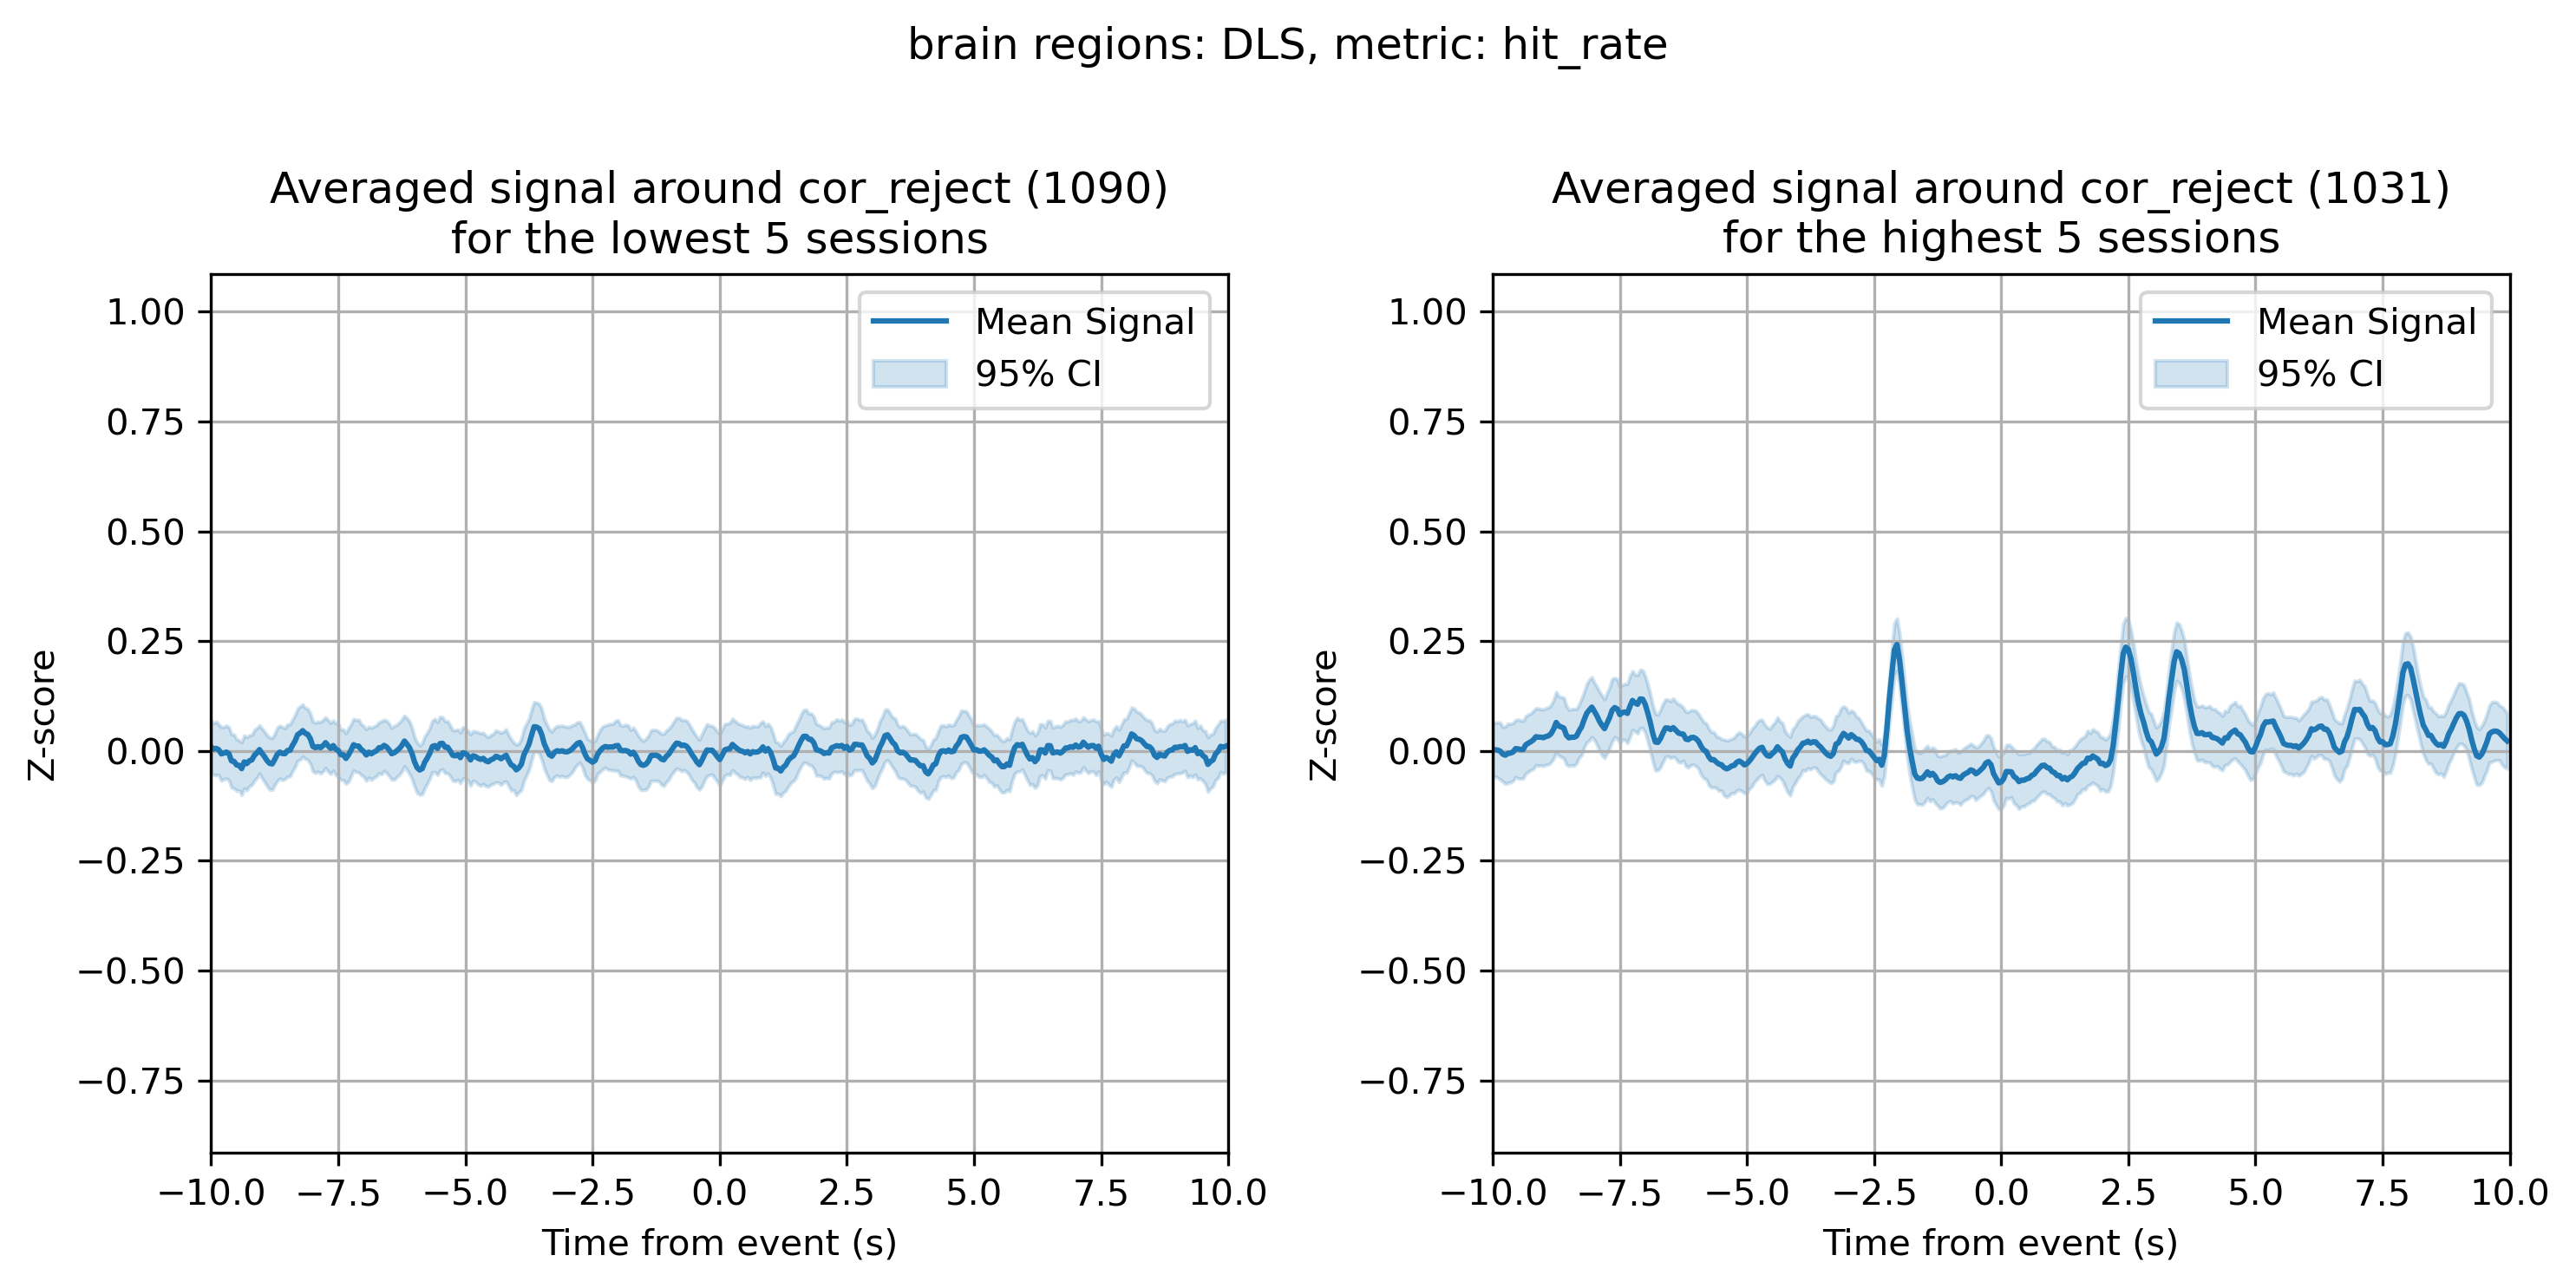

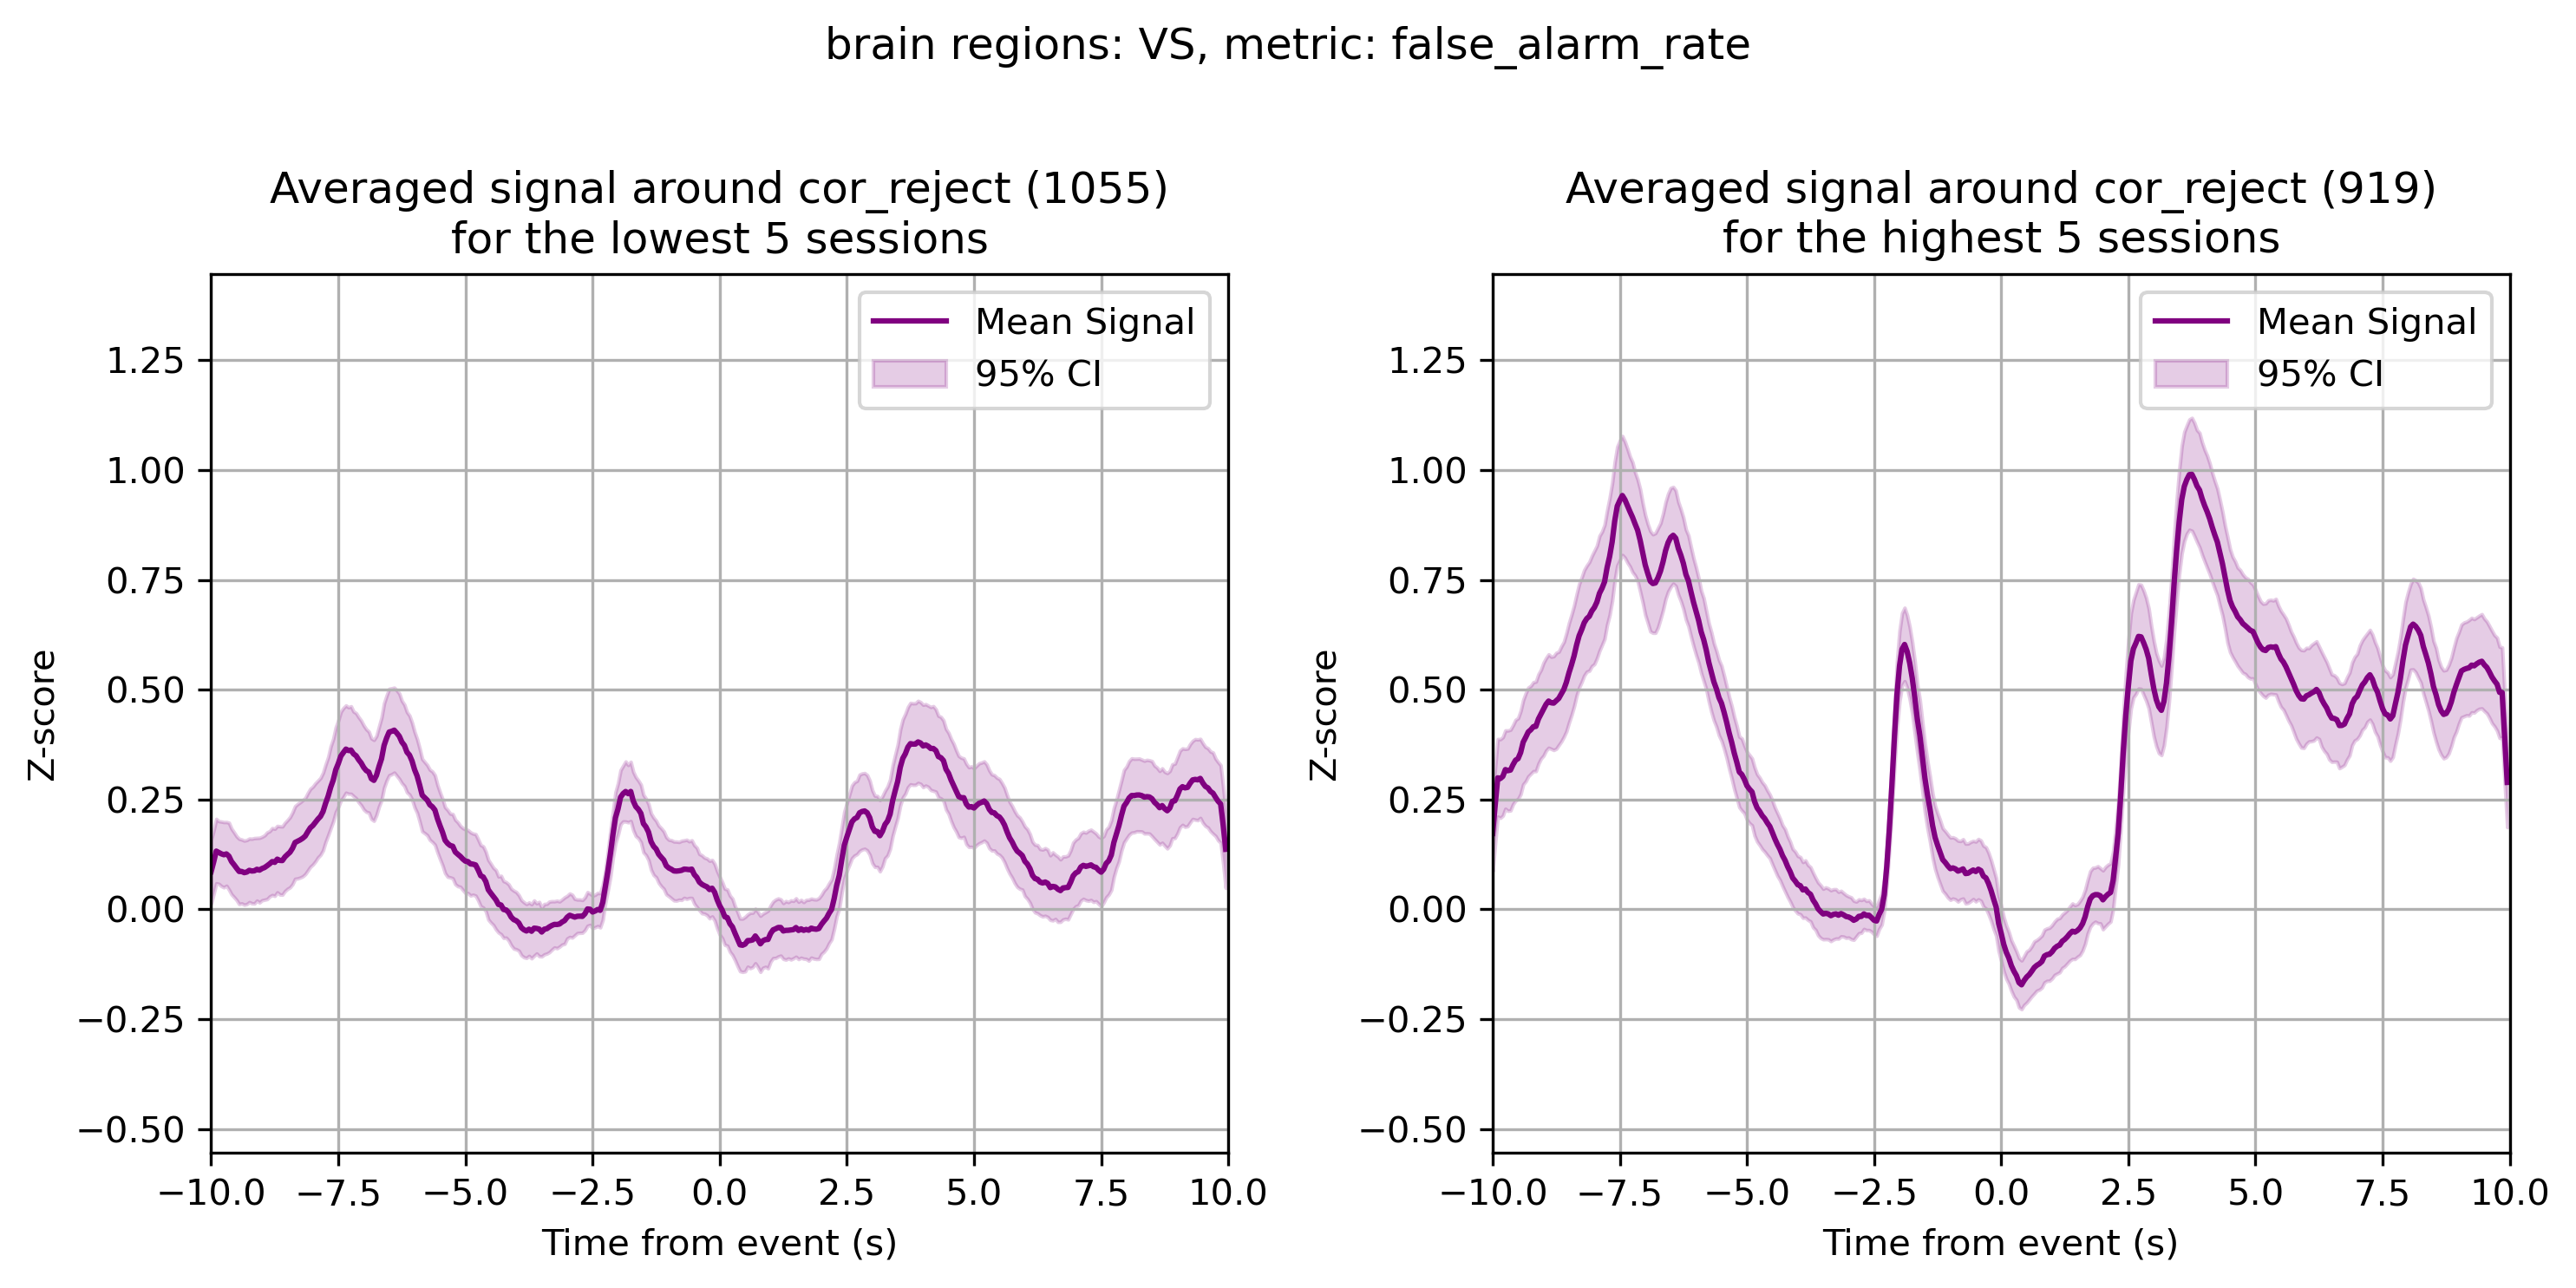

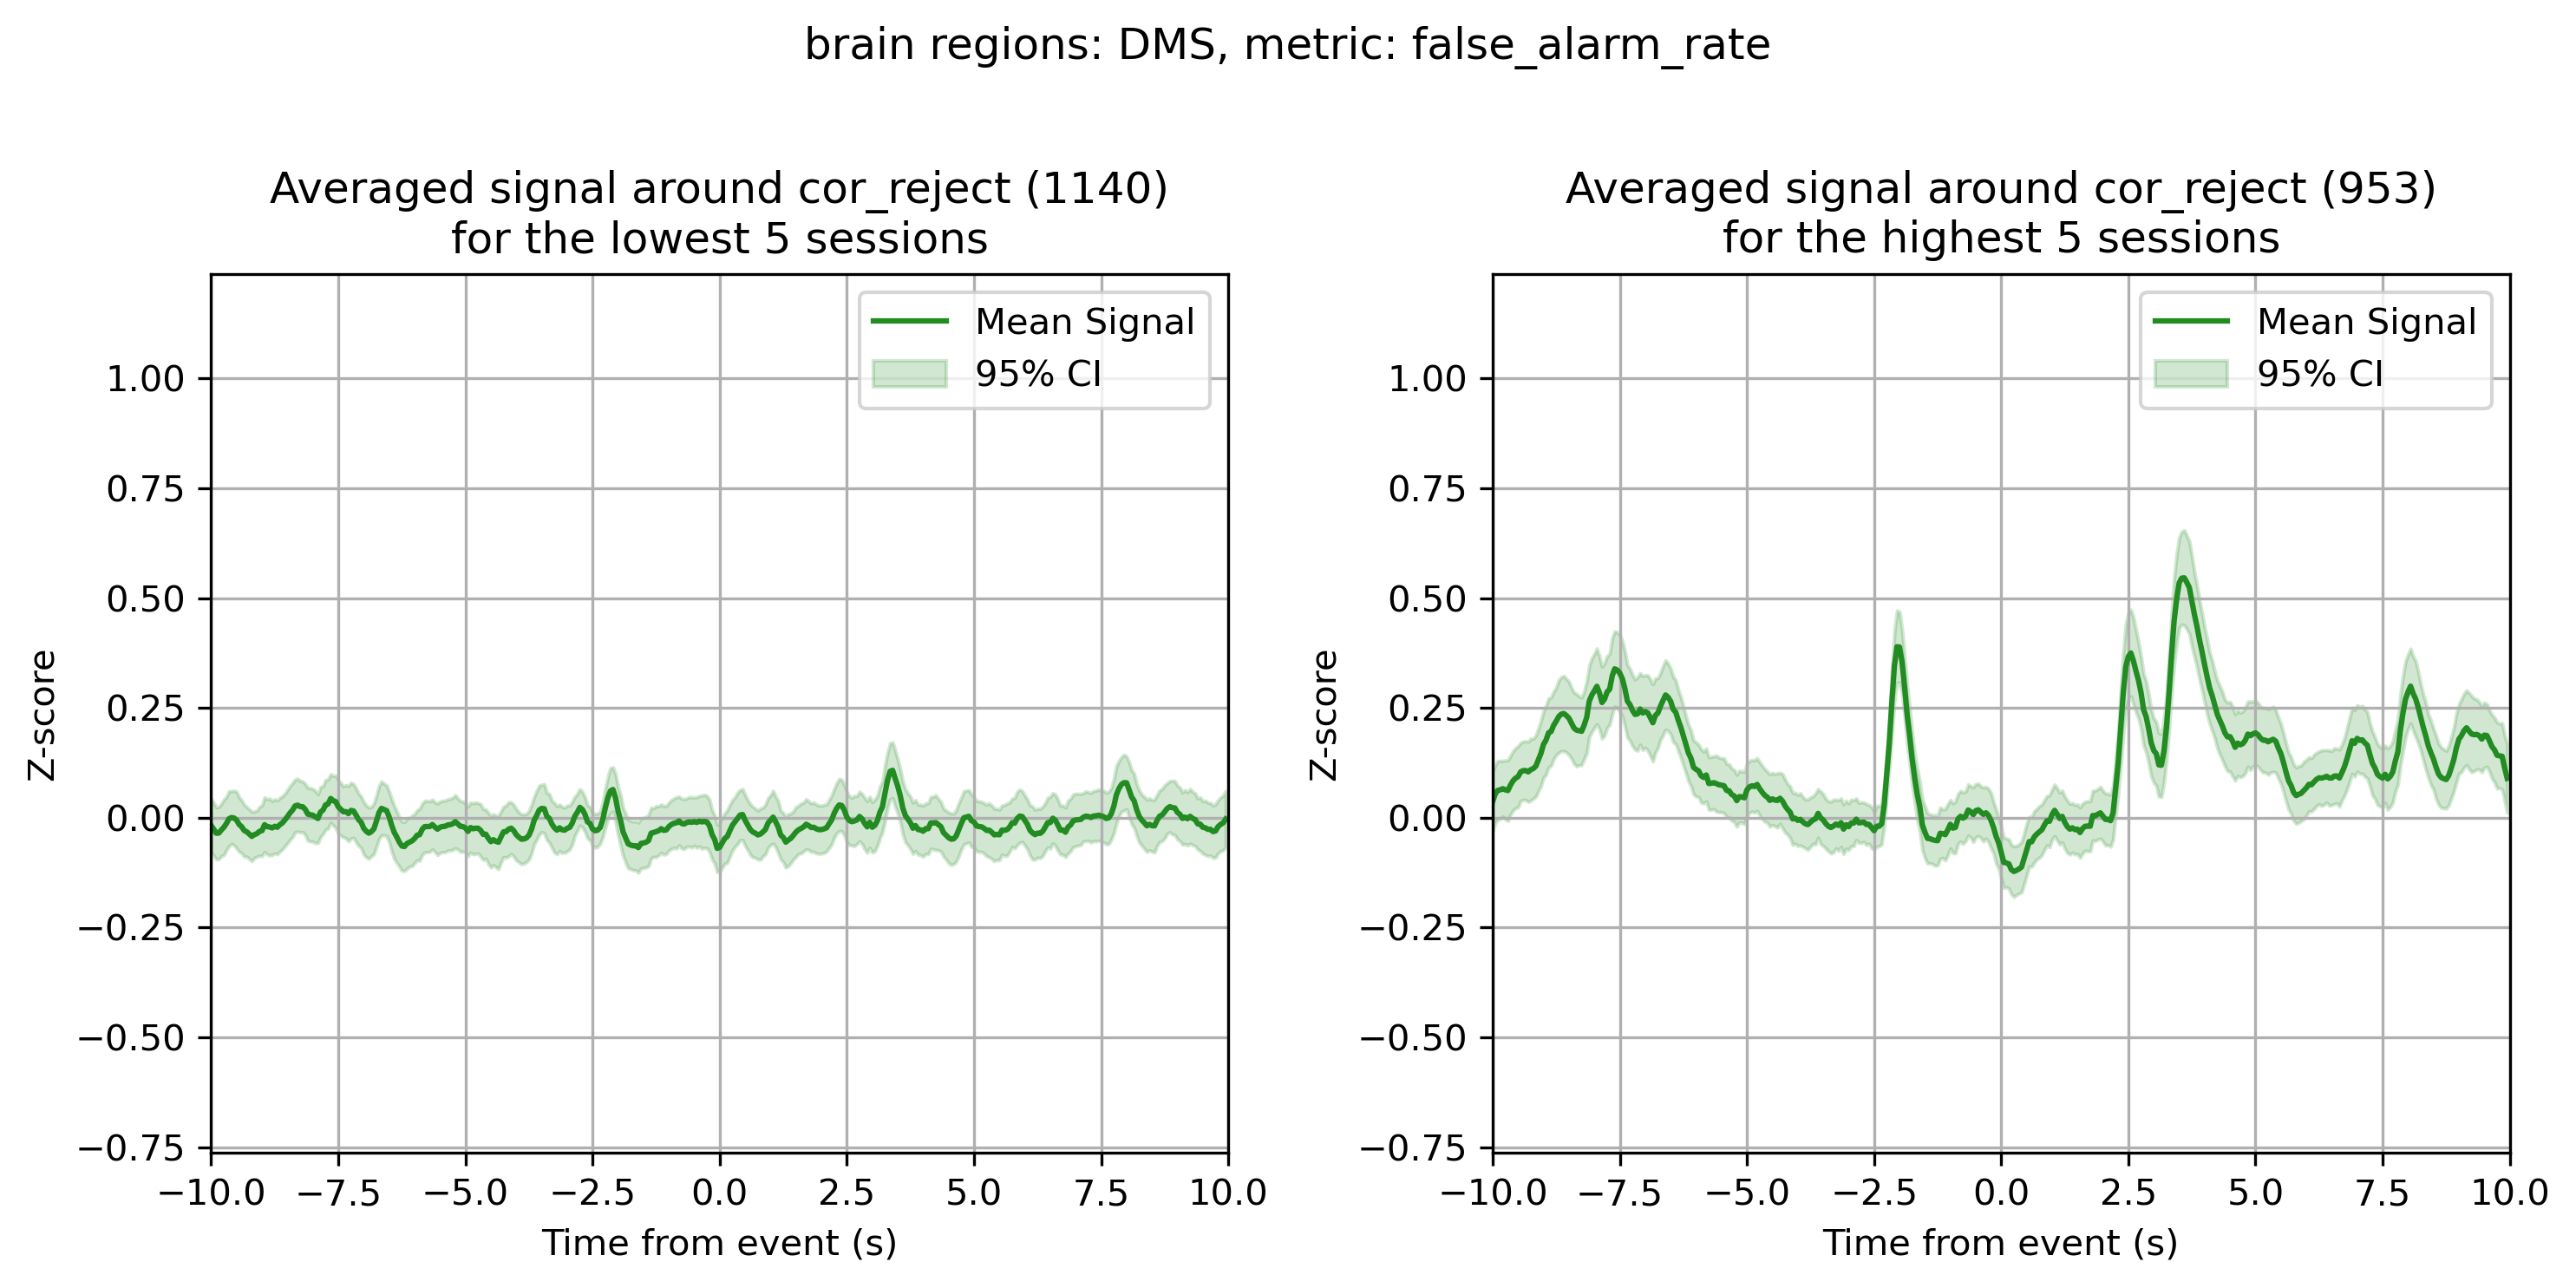

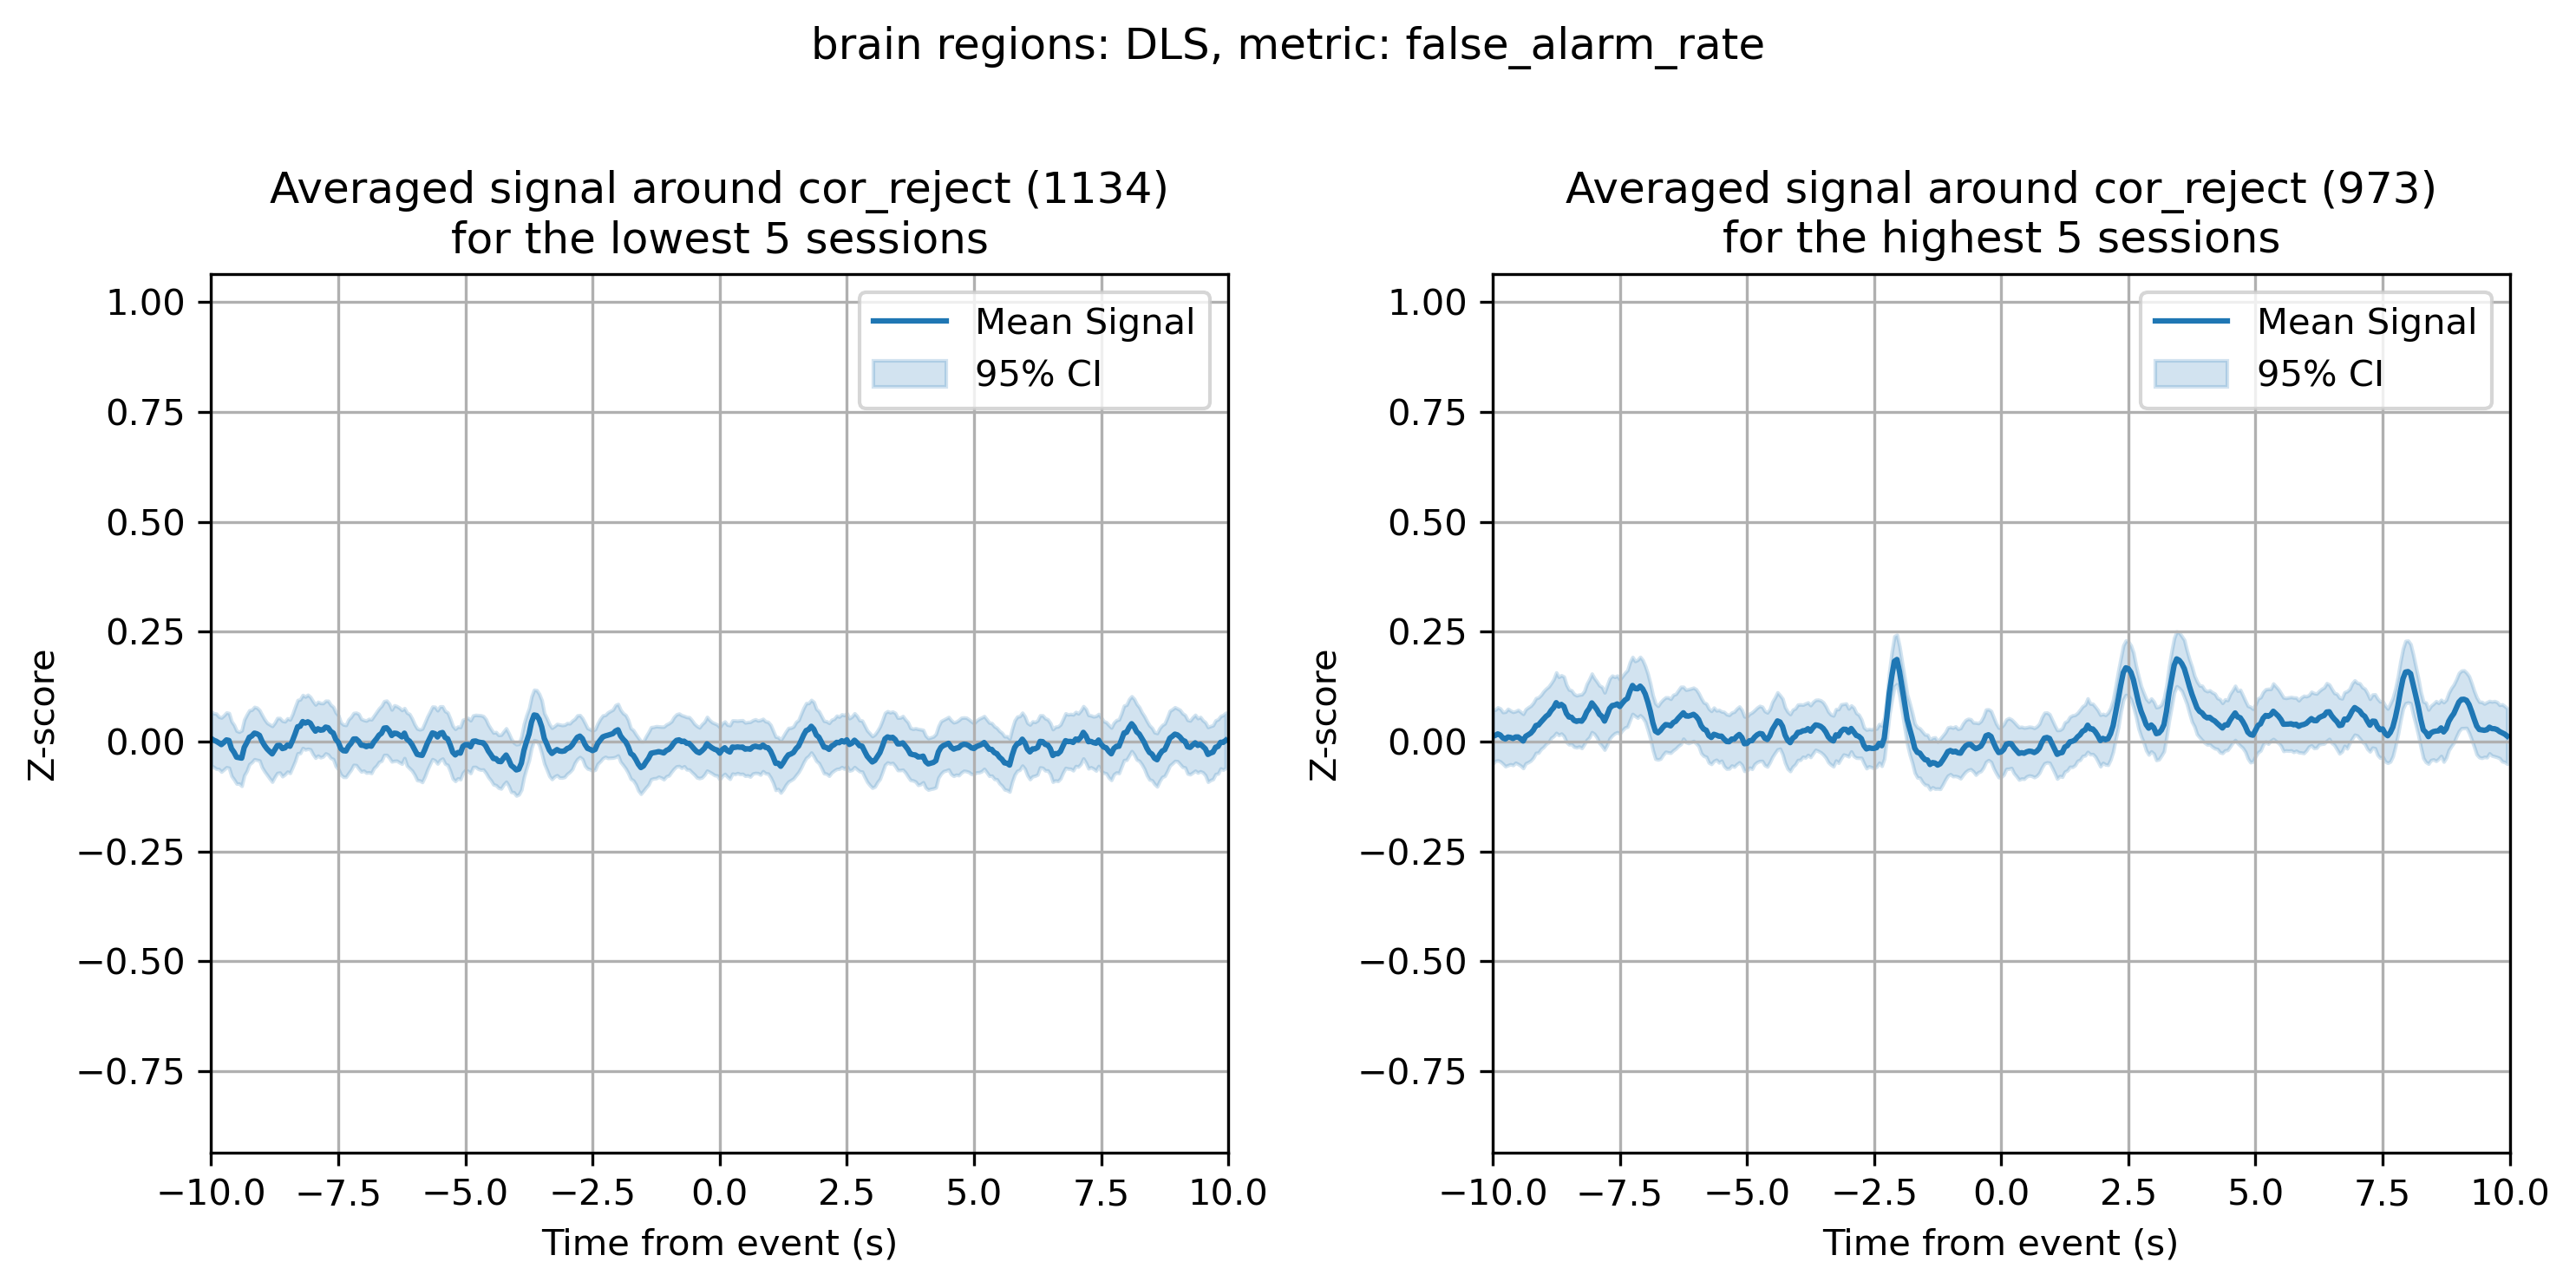

In [11]:
all_colors = ['purple', 'forestgreen', 'C0']

def is_relevant_session(brain_regions, event_type, idx):
    curr_session = sessions[idx]
    return ((brain_regions[0] in curr_session.brain_regions or brain_regions[1] in curr_session.brain_regions)
            and curr_session.timepoints_container.get_data(event_type))


for metric, session_order in metric_session_order.items():
    # if metric != 'c_score':
    #     continue
    for brain_regions, color in zip([['VS_left', 'VS_right']],
                                      all_colors):
    # for brain_regions, color in zip([['VS_left', 'VS_right'], ['DMS_left', 'DMS_right'], ['DLS_left', 'DLS_right']],
                                     all_colors):
        # for event_type in ['before_dispimg_mistake']:
        for event_type in ['hit']:    
        # for event_type in ['hit', 'mistake', 'miss', 'cor_reject', 'reward_collect']:
            ordered_filtered_sessions = [sessions[idx] for idx in session_order if 
                                         is_relevant_session(brain_regions, event_type, idx)]

            worst_sessions = ordered_filtered_sessions[:5]
            best_sessions = ordered_filtered_sessions[-5:]

            suffix = f"{metric}, {brain_regions[0].split('_')[0]}, {event_type}"

            #print(metric, brain_regions[0].split('_')[0], event_type)
            fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, dpi=300)
            
            worst_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in worst_sessions)
            
            best_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in best_sessions)

            bad_subtitle = f"Averaged signal around {event_type} ({worst_total})\nfor the lowest 5 sessions"
            good_subtitle = f"Averaged signal around {event_type} ({best_total})\nfor the highest 5 sessions"

            lbs = []
            ubs = []
            for curr_sessions, subtitles, ax in zip([worst_sessions, best_sessions], [bad_subtitle, good_subtitle], [ax1, ax2]):            
                xs, ys, lb, ub, _ = aggregate_signals(curr_sessions, event_type, brain_regions, 
                                                        aggregate_by_session=False, normalize_baseline=True)
                lbs.append(lb)
                ubs.append(ub)

                ax.plot(xs, ys, label='Mean Signal', color=color)
                ax.fill_between(xs, lb, ub, color=color, alpha=0.2, label='95% CI')
                ax.set_title(subtitles)  # Including AUC in the subtitle
                ax.set_xlabel("Time from event (s)")
                ax.set_ylabel("Z-score")
                ax.legend()
            
            plt.suptitle(f"brain regions: {brain_regions[0].split('_')[0]}, metric: {metric}\n")

            brain_region_name = brain_regions[0].split('_')[0]
            lb = min(lbs[0].min(), lbs[1].min())
            ub = max(ubs[0].max(), ubs[1].max())
                    
            # if ub - lb < 3.5:
            #     plt.clf()
            #     continue
            for ax in (ax1, ax2):
                if (ub - lb) < 2:
                    ax.set_ylim((lb + ub) / 2 - 1, (lb + ub) / 2 + 1)    
                else:
                    ax.set_ylim(lb, ub)    
                ax.set_xlim(-10, 10)
                ax.grid()
            
            
            plt.tight_layout()
            plt.show()
            #plt.savefig(f'{metric}_{event_type}_{brain_region_name}.png', dpi=300)
        

